In [171]:
%matplotlib inline

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.special import comb

## Exploratory Data Analysis

In [173]:
cc_df = pd.read_csv('AnonymousBank/September1999.txt', sep='\t')

cc_df.head()

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
0,AA0101,44727,0.0,0,PS,990901,0:02:41,0:02:57,16,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER
1,AA0101,44728,0.0,0,PS,990901,6:45:26,6:46:04,38,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER
2,AA0101,44729,1161660.0,2,PS,990901,7:30:37,7:30:43,6,7:30:43,7:31:22,39,AGENT,7:31:21,7:33:11,110,BASCH
3,AA0101,44730,0.0,0,PS,990901,7:54:21,7:54:32,11,0:00:00,0:00:00,0,AGENT,7:54:30,7:56:58,148,BASCH
4,AA0101,44731,0.0,0,PS,990901,8:09:37,8:09:48,11,0:00:00,0:00:00,0,AGENT,8:09:47,8:10:41,54,ZOHARI


In [174]:
# We identified an error in the 'vru_exit' column where the separator was incorrect (see 'priority' column)
cc_df.iloc[9664]

vru+line           AA0111
call_id              4137
customer_id           0.0
priority       0       TT
type               990914
date              9:47:23
vru_entry         9:47:29
vru_exit                6
vru_time          0:00:00
q_start           0:00:00
q_exit                  0
q_time               HANG
outcome           0:00:00
ser_start         0:00:00
ser_exit                0
ser_time        NO_SERVER
server                NaN
Name: 9664, dtype: object

In [175]:
# Since it a 'HANG' outcome, let's just drop this row
cc_df = cc_df.drop(9664)

In [176]:
# Change date column types to datetime
cc_df['date'] = pd.to_datetime(cc_df['date'], format='%y%m%d')

# Change time columns to datetime
cc_df['vru_entry'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_entry'], format='%Y-%m-%d %H:%M:%S')
cc_df['vru_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_exit'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_start'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_start'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_exit'], format='%Y-%m-%d %H:%M:%S')

# Change number columns to numeric
cc_df['vru_time'] = pd.to_numeric(cc_df['vru_time'], errors='coerce')
cc_df['q_time'] = pd.to_numeric(cc_df['q_time'], errors='coerce')
cc_df['ser_time'] = pd.to_numeric(cc_df['ser_time'], errors='coerce')

# Only keep rows with 'AGENT' in the 'outcome' column
cc_df = cc_df[cc_df['outcome'] == 'AGENT']

# Drop unnecessary columns
cc_df = cc_df.drop(columns=['vru+line', 'customer_id', 'priority'])

# Display the first few rows of the cleaned DataFrame
cc_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
2,44729,PS,1999-09-01,1999-09-01 07:30:37,1999-09-01 07:30:43,6,7:30:43,7:31:22,39,AGENT,1999-09-01 07:31:21,1999-09-01 07:33:11,110,BASCH
3,44730,PS,1999-09-01,1999-09-01 07:54:21,1999-09-01 07:54:32,11,0:00:00,0:00:00,0,AGENT,1999-09-01 07:54:30,1999-09-01 07:56:58,148,BASCH
4,44731,PS,1999-09-01,1999-09-01 08:09:37,1999-09-01 08:09:48,11,0:00:00,0:00:00,0,AGENT,1999-09-01 08:09:47,1999-09-01 08:10:41,54,ZOHARI
5,44732,PS,1999-09-01,1999-09-01 08:28:41,1999-09-01 08:28:50,9,0:00:00,0:00:00,0,AGENT,1999-09-01 08:28:49,1999-09-01 08:29:59,70,STEREN
6,44733,PS,1999-09-01,1999-09-01 08:39:06,1999-09-01 08:39:16,10,0:00:00,0:00:00,0,AGENT,1999-09-01 08:39:14,1999-09-01 08:40:08,54,ZOHARI


In [177]:
# Check rows with zero service time
cc_df[cc_df['ser_time'] == 0]

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
442,45170,PS,1999-09-08,1999-09-08 16:42:33,1999-09-08 16:42:39,6,16:42:39,16:44:08,89,AGENT,1999-09-08 16:44:08,1999-09-08 16:44:08,0,AVI
767,45499,PS,1999-09-15,1999-09-15 18:41:38,1999-09-15 18:41:49,11,0:00:00,0:00:00,0,AGENT,1999-09-15 18:41:49,1999-09-15 18:41:49,0,AVI
846,45578,PS,1999-09-16,1999-09-16 22:11:35,1999-09-16 22:11:40,5,22:11:40,22:14:23,163,AGENT,1999-09-16 22:14:23,1999-09-16 22:14:23,0,AVI
1060,45794,NE,1999-09-23,1999-09-23 10:53:10,1999-09-23 10:53:16,6,10:53:16,10:53:50,34,AGENT,1999-09-23 10:53:50,1999-09-23 10:53:50,0,ANAT
1488,35969,PS,1999-09-02,1999-09-02 20:46:30,1999-09-02 20:46:36,6,20:46:36,20:49:18,162,AGENT,1999-09-02 20:49:17,1999-09-02 20:49:17,0,AVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31056,11721,IN,1999-09-23,1999-09-23 10:37:47,1999-09-23 10:38:01,14,0:00:00,0:00:00,0,AGENT,1999-09-23 10:38:00,1999-09-23 10:38:00,0,YIFAT
31074,11739,IN,1999-09-23,1999-09-23 14:34:32,1999-09-23 14:34:46,14,0:00:00,0:00:00,0,AGENT,1999-09-23 00:00:00,1999-09-23 00:00:00,0,Z2IFAT
31161,11827,IN,1999-09-26,1999-09-26 15:02:07,1999-09-26 15:02:22,15,0:00:00,0:00:00,0,AGENT,1999-09-26 00:00:00,1999-09-26 00:00:00,0,Z2ARIE
31224,11890,IN,1999-09-27,1999-09-27 17:43:21,1999-09-27 17:43:35,14,0:00:00,0:00:00,0,AGENT,1999-09-27 00:00:00,1999-09-27 00:00:00,0,Z2IFAT


In [239]:
cc_df['ser_time'].describe()

count    26910.000000
mean       192.562133
std        295.248698
min          1.000000
25%         60.000000
50%        112.000000
75%        215.000000
max      14389.000000
Name: ser_time, dtype: float64

In [178]:
# Remove rows with arrival time earlier than 7:00 AM
cc_df = cc_df[cc_df['vru_entry'].dt.hour >= 7]

# Remove rows with service time less than equal to 0
cc_df = cc_df[cc_df['ser_time'] > 0]

In [179]:
# Group the data by type and calculate the number of calls per type
cc_df_grouped = cc_df.groupby('type')

cc_df_grouped_count = cc_df_grouped.size().reset_index(name='count')
cc_df_grouped_count = cc_df_grouped_count.sort_values(by='count', ascending=False)

# Display the counts of each call type
cc_df_grouped_count

,type,count
4,PS,18512
2,NW,2911
0,IN,2616
1,NE,2496
5,TT,288
3,PE,87


In [180]:
# Display the first few rows of the grouped DataFrame
cc_df_grouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
2,44729,PS,1999-09-01,1999-09-01 07:30:37,1999-09-01 07:30:43,6,7:30:43,7:31:22,39,AGENT,1999-09-01 07:31:21,1999-09-01 07:33:11,110,BASCH
3,44730,PS,1999-09-01,1999-09-01 07:54:21,1999-09-01 07:54:32,11,0:00:00,0:00:00,0,AGENT,1999-09-01 07:54:30,1999-09-01 07:56:58,148,BASCH
4,44731,PS,1999-09-01,1999-09-01 08:09:37,1999-09-01 08:09:48,11,0:00:00,0:00:00,0,AGENT,1999-09-01 08:09:47,1999-09-01 08:10:41,54,ZOHARI
5,44732,PS,1999-09-01,1999-09-01 08:28:41,1999-09-01 08:28:50,9,0:00:00,0:00:00,0,AGENT,1999-09-01 08:28:49,1999-09-01 08:29:59,70,STEREN
6,44733,PS,1999-09-01,1999-09-01 08:39:06,1999-09-01 08:39:16,10,0:00:00,0:00:00,0,AGENT,1999-09-01 08:39:14,1999-09-01 08:40:08,54,ZOHARI
7,44734,NW,1999-09-01,1999-09-01 08:55:19,1999-09-01 08:55:29,10,0:00:00,0:00:00,0,AGENT,1999-09-01 08:55:40,1999-09-01 08:55:44,4,NO_SERVER
15,44742,NW,1999-09-01,1999-09-01 10:23:32,1999-09-01 10:23:41,9,10:23:41,10:23:47,6,AGENT,1999-09-01 10:23:46,1999-09-01 10:25:21,95,STEREN
21,44748,NW,1999-09-01,1999-09-01 11:35:49,1999-09-01 11:36:02,13,0:00:00,0:00:00,0,AGENT,1999-09-01 11:36:01,1999-09-01 11:38:15,134,AVNI
25,44752,NW,1999-09-01,1999-09-01 12:24:56,1999-09-01 12:25:11,15,0:00:00,0:00:00,0,AGENT,1999-09-01 12:25:12,1999-09-01 12:25:35,23,NO_SERVER
29,44756,NW,1999-09-01,1999-09-01 13:25:12,1999-09-01 13:25:25,13,0:00:00,0:00:00,0,AGENT,1999-09-01 13:25:24,1999-09-01 13:26:18,54,STEREN


Text(0.5, 1.0, 'Number of Calls per Type')

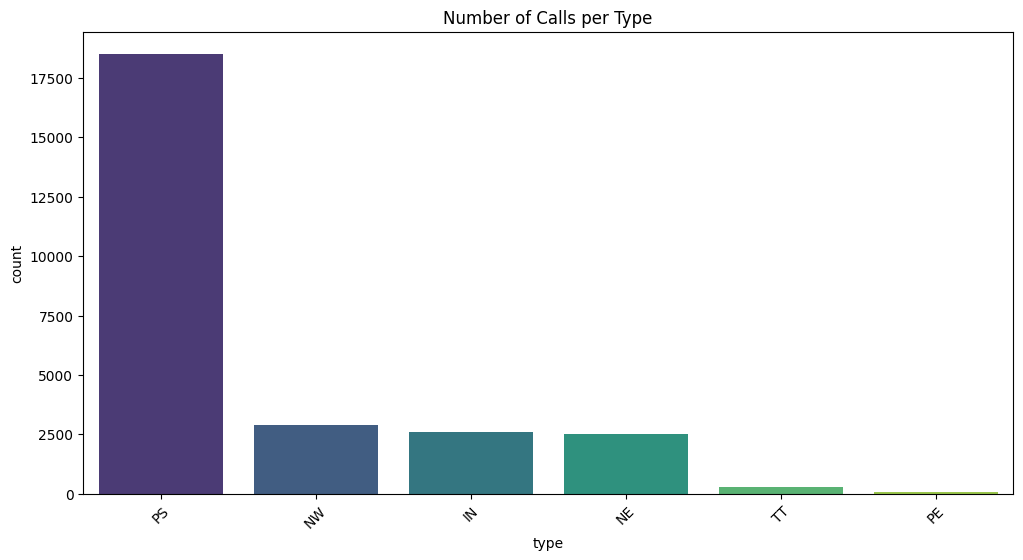

In [181]:
# Plot the number of calls per type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='count', data=cc_df_grouped_count, palette='viridis', hue='type')
plt.xticks(rotation=45)
plt.title('Number of Calls per Type')

In [182]:
# Describe service times of each type dataframes
cc_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
IN,2616.0,472.048930,649.452879,1.0,109.00,248.0,586.00,14389.0
NE,2496.0,234.061298,323.678145,1.0,68.00,148.0,278.00,7387.0
NW,2911.0,109.505325,186.209328,1.0,33.00,63.0,124.00,4619.0
PE,87.0,277.586207,288.876998,2.0,98.50,211.0,320.50,1433.0
PS,18512.0,161.293971,181.093660,1.0,63.00,109.0,195.00,4036.0
TT,288.0,117.902778,244.318360,1.0,8.75,51.5,130.25,2871.0


In [183]:
# Check the rows with the longest service times for each type
longest_service_times = cc_df.loc[cc_df_grouped['ser_time'].idxmax()]
longest_service_times

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
29894,10558,IN,1999-09-02,1999-09-02 10:46:43,1999-09-02 10:47:01,18,0:00:00,0:00:00,0,AGENT,1999-09-02 10:47:00,1999-09-02 14:46:49,14389,Z2IFAT
16337,48164,NE,1999-09-21,1999-09-21 12:12:47,1999-09-21 12:12:53,6,12:12:53,12:13:11,18,AGENT,1999-09-21 12:13:10,1999-09-21 14:16:17,7387,ELI
25793,45870,NW,1999-09-30,1999-09-30 15:23:00,1999-09-30 15:23:10,10,15:23:10,15:23:46,36,AGENT,1999-09-30 15:23:46,1999-09-30 16:40:45,4619,PINHAS
18547,48842,PE,1999-09-16,1999-09-16 11:58:38,1999-09-16 11:58:43,5,11:58:43,12:00:31,108,AGENT,1999-09-16 12:00:30,1999-09-16 12:24:23,1433,MORIAH
20364,50627,PS,1999-09-29,1999-09-29 12:03:34,1999-09-29 12:03:40,6,12:03:40,12:04:39,59,AGENT,1999-09-29 12:04:38,1999-09-29 13:11:54,4036,AVNI
9732,4205,TT,1999-09-30,1999-09-30 14:35:46,1999-09-30 14:35:48,2,0:00:00,0:00:00,0,AGENT,1999-09-30 14:35:47,1999-09-30 15:23:38,2871,NO_SERVER


In [184]:
# Omit rows where 'ser_time' is the maximum within each 'call_type'
cc_df_grouped_omit = cc_df.drop(cc_df_grouped['ser_time'].idxmax())

cc_df_grouped_omit = cc_df_grouped_omit.groupby('type')

cc_df_grouped_omit['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
IN,2615.0,466.726960,589.769563,1.0,109.00,248.0,585.0,5627.0
NE,2495.0,231.194389,290.320991,1.0,68.00,148.0,277.5,3206.0
NW,2910.0,107.955670,166.411749,1.0,33.00,63.0,124.0,3947.0
PE,86.0,264.151163,261.807946,2.0,98.25,211.0,316.5,1239.0
PS,18511.0,161.084652,178.845038,1.0,63.00,109.0,195.0,3158.0
TT,287.0,108.310105,182.499118,1.0,8.50,51.0,129.5,1860.0


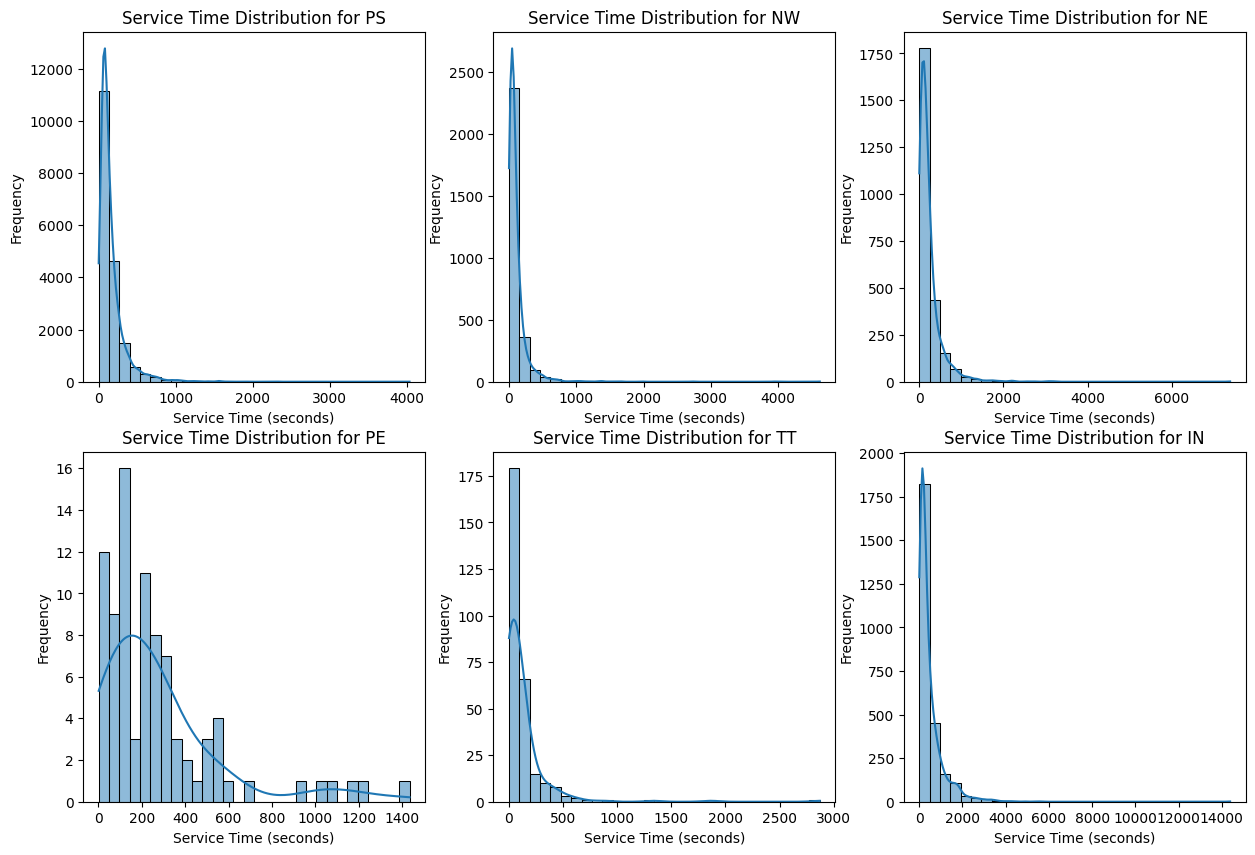

In [185]:
# Plot histogram of service times for each call type
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, call_type in enumerate(cc_df['type'].unique()):
    sns.histplot(cc_df[cc_df['type'] == call_type]['ser_time'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Service Time Distribution for {call_type}')
    axes[i].set_xlabel('Service Time (seconds)')
    axes[i].set_ylabel('Frequency')

In [186]:
import scipy.stats as stats

# QQ plot against exponential distribution
def qq_plot_exp(data, title):
    stats.probplot(data, dist="expon", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
# QQ plot against lognormal distribution
def qq_plot_lognorm(data, title):
    shape, loc, scale = stats.lognorm.fit(data, floc=0)
    stats.probplot(data, dist="lognorm", sparams=(shape, loc, scale), plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

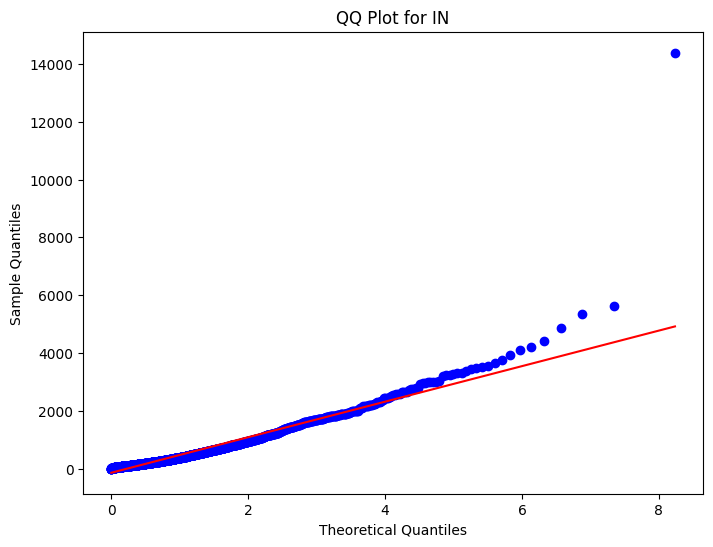

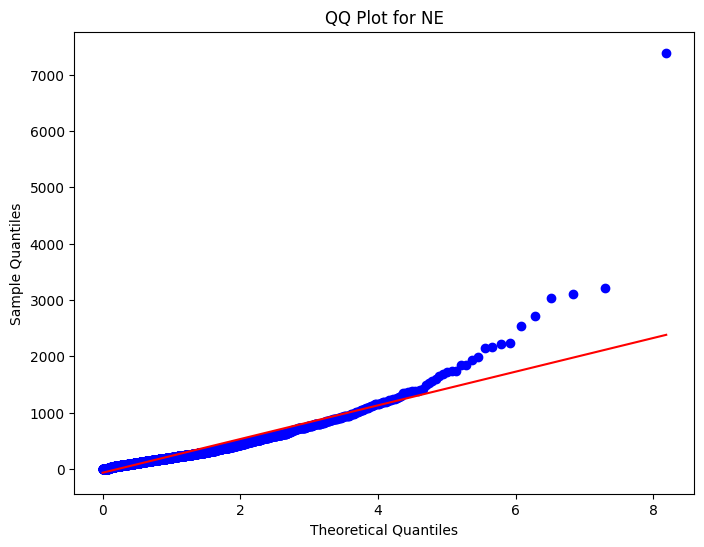

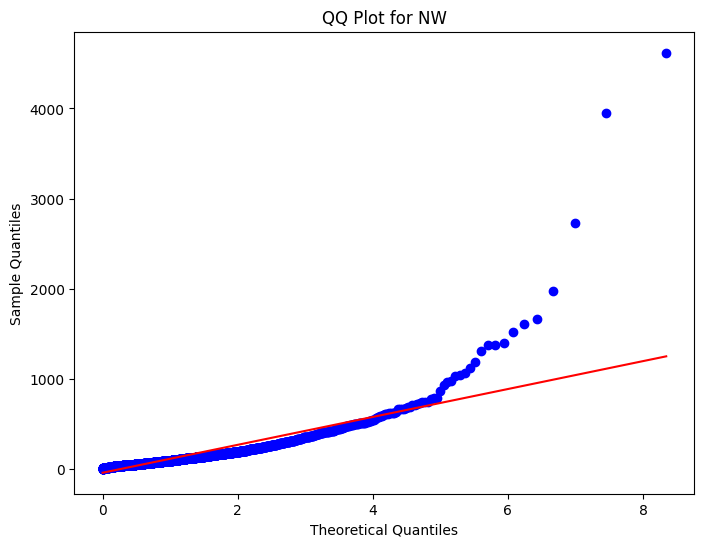

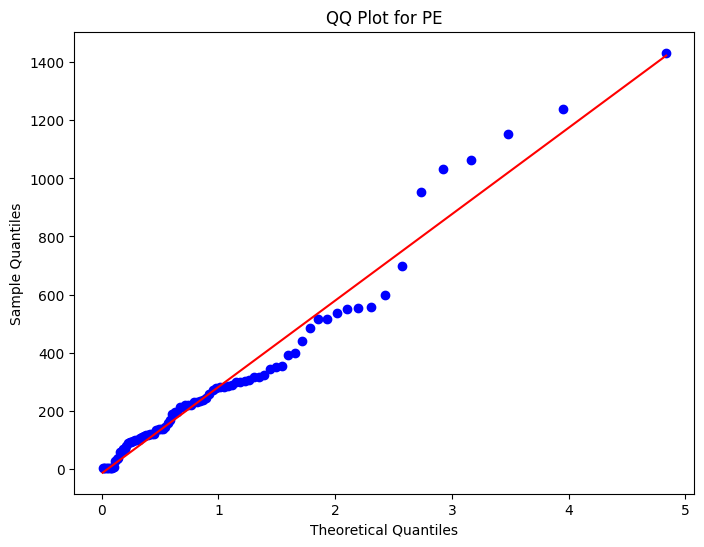

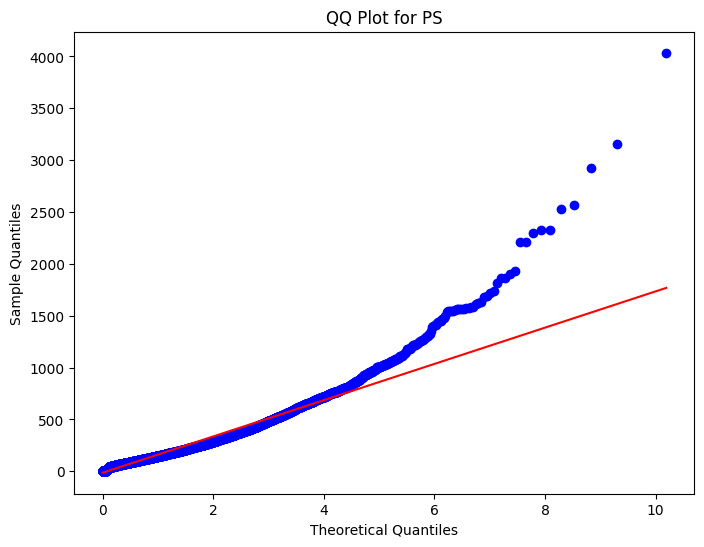

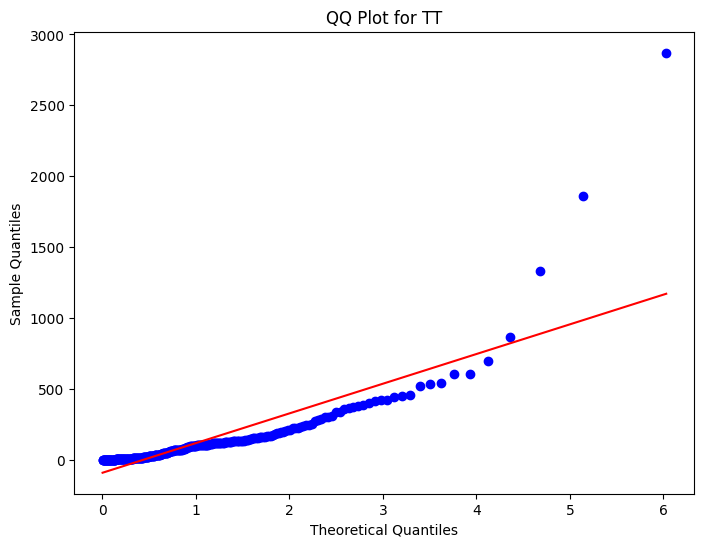

In [187]:
for call_type, group in cc_df_grouped:
    plt.figure(figsize=(8, 6))
    qq_plot_exp(group['ser_time'], f'QQ Plot for {call_type}')
    plt.show()

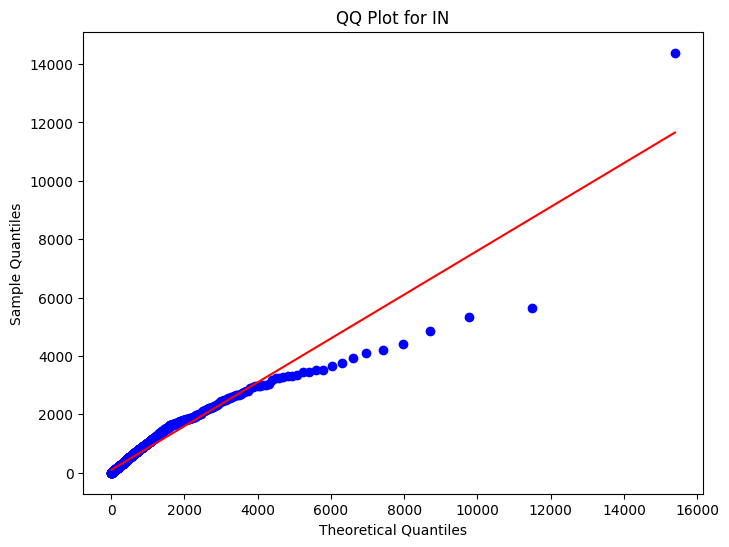

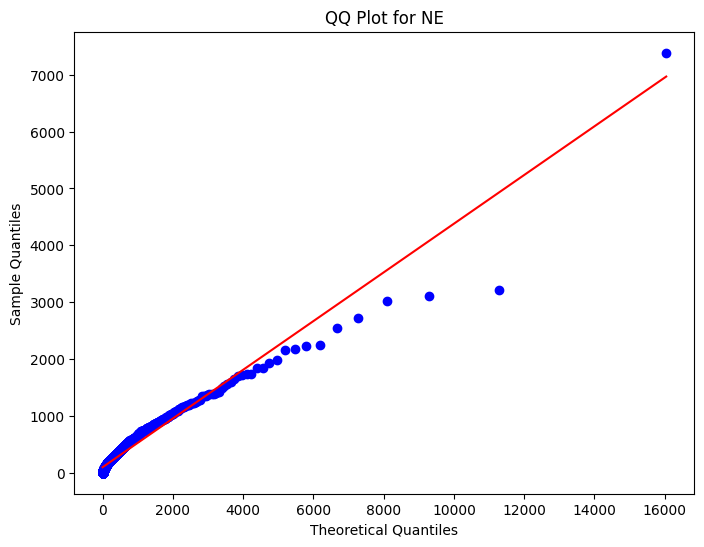

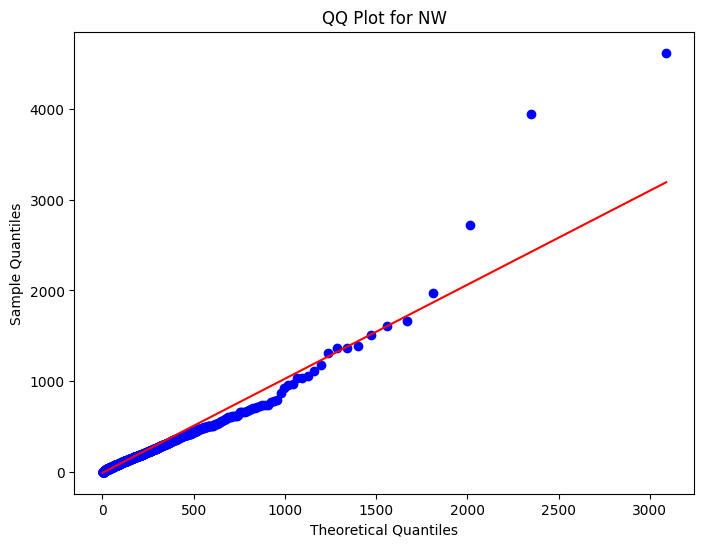

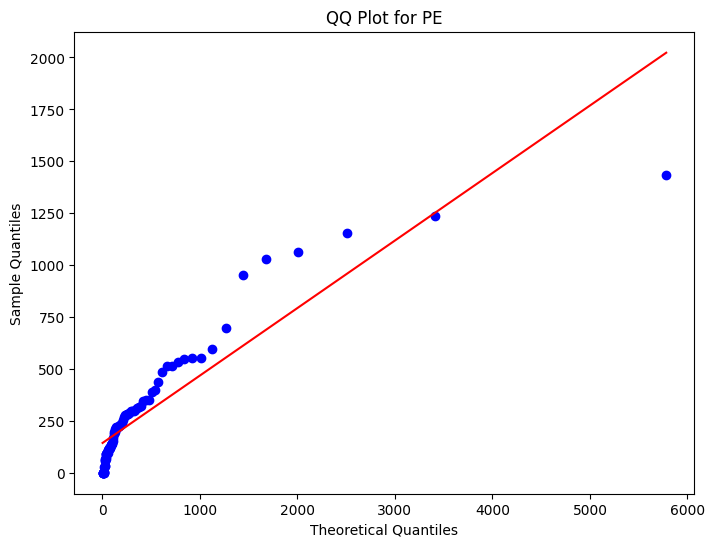

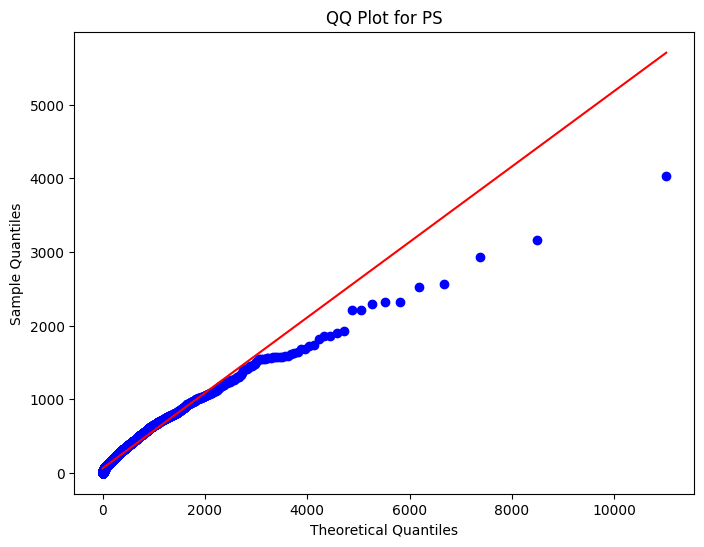

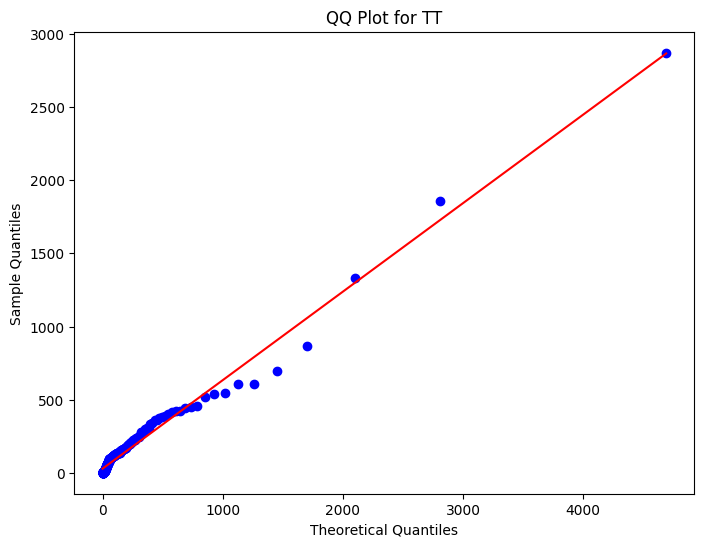

In [188]:
# Against lognormal distribution
for call_type, group in cc_df_grouped:
    plt.figure(figsize=(8, 6))
    qq_plot_lognorm(group['ser_time'], f'QQ Plot for {call_type}')
    plt.show()

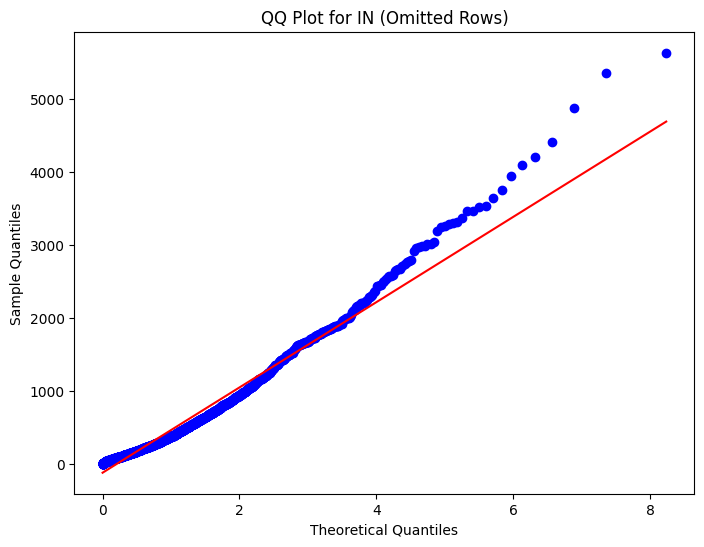

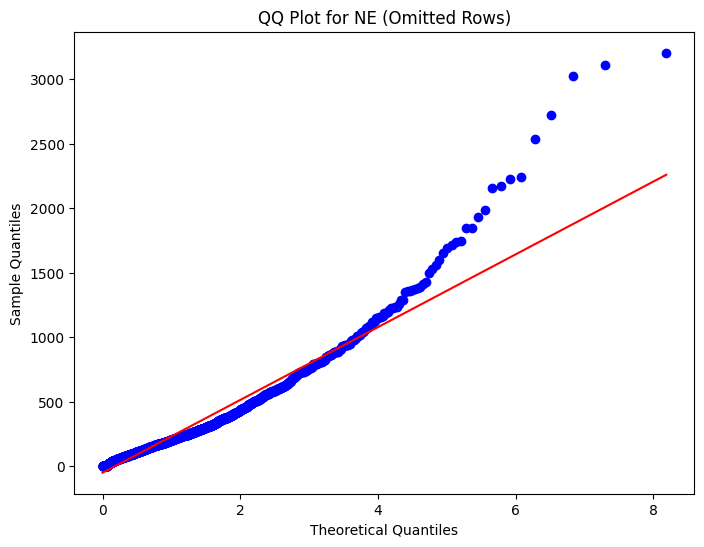

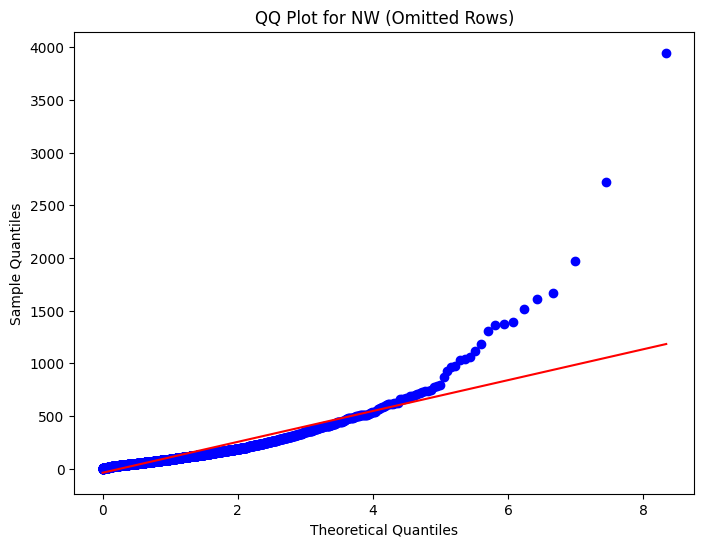

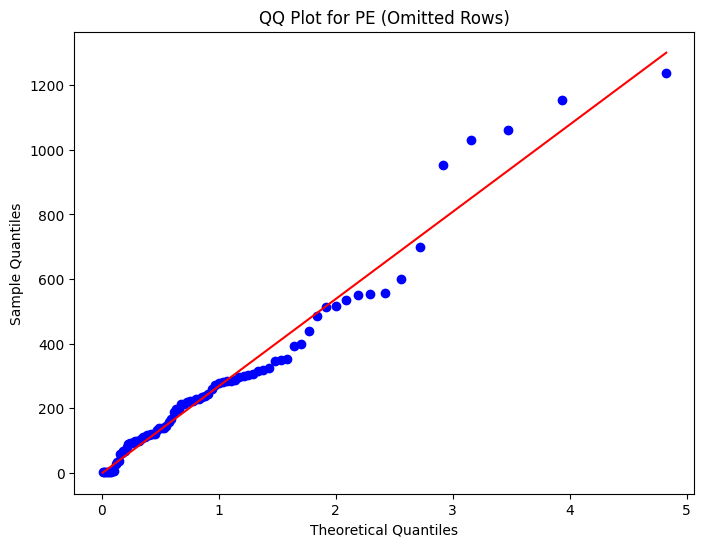

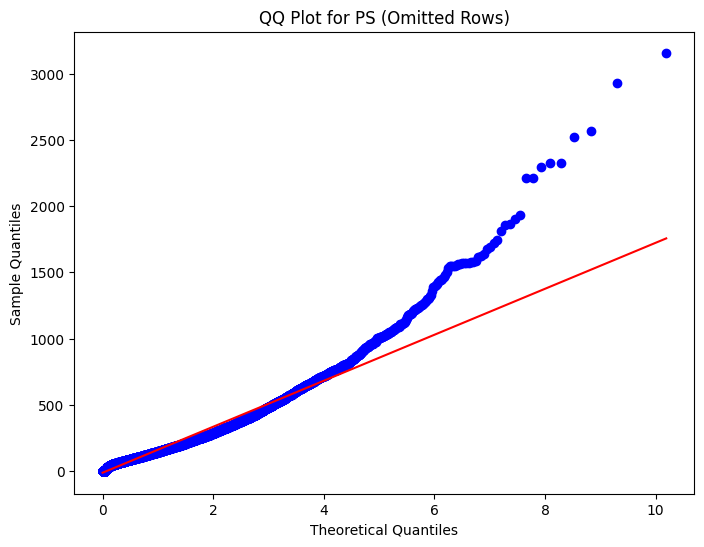

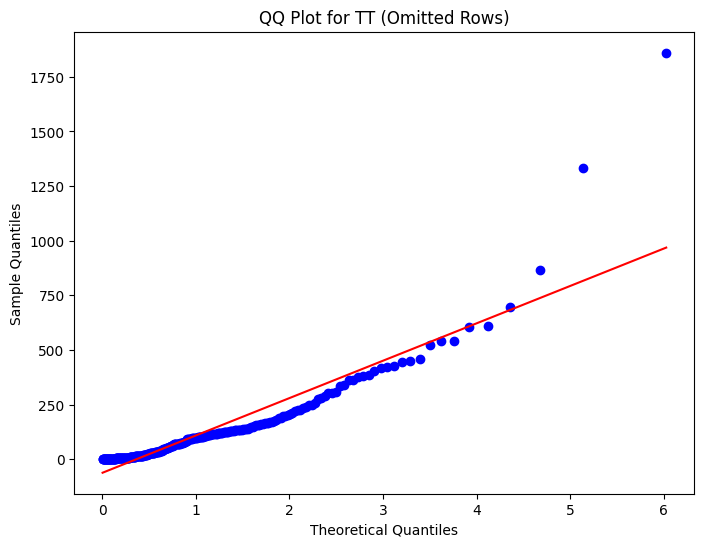

In [189]:
# QQ plot without omitted rows
for call_type, group in cc_df_grouped_omit:
    plt.figure(figsize=(8, 6))
    qq_plot_exp(group['ser_time'], f'QQ Plot for {call_type} (Omitted Rows)')
    plt.show()

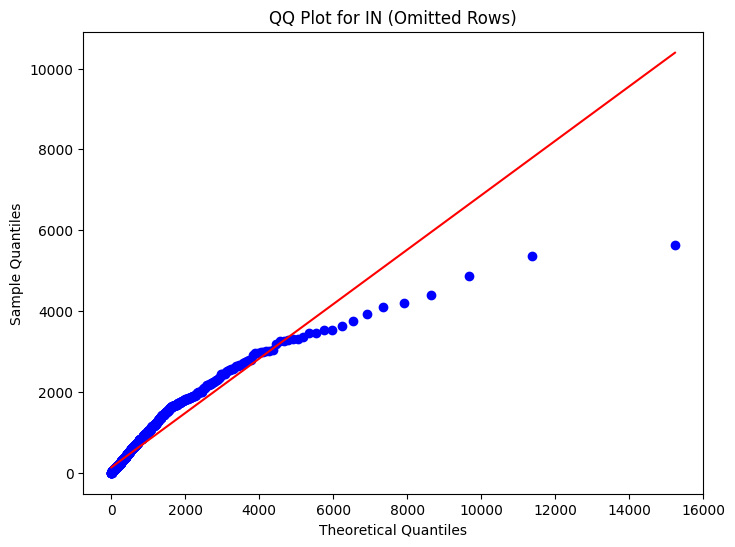

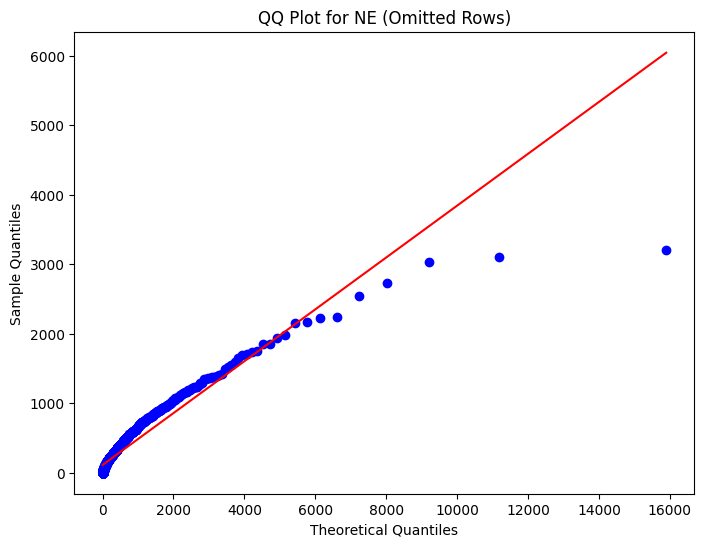

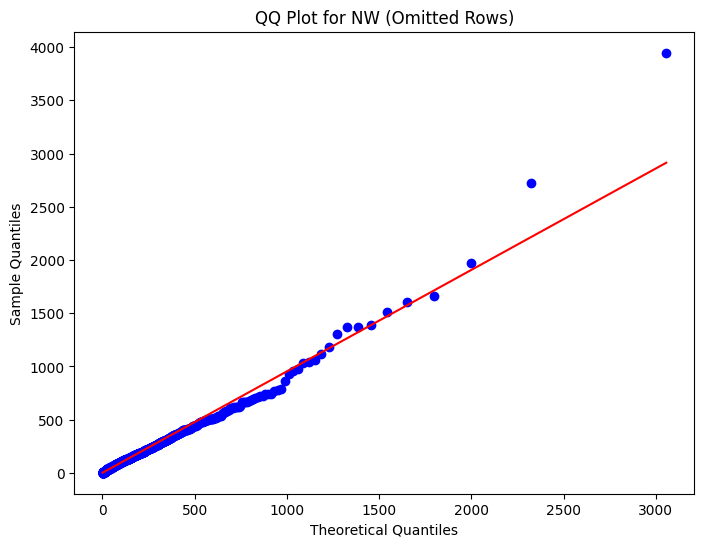

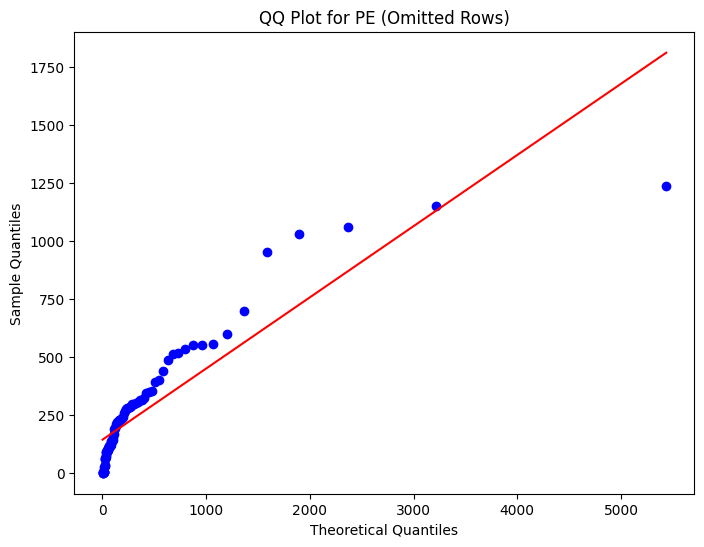

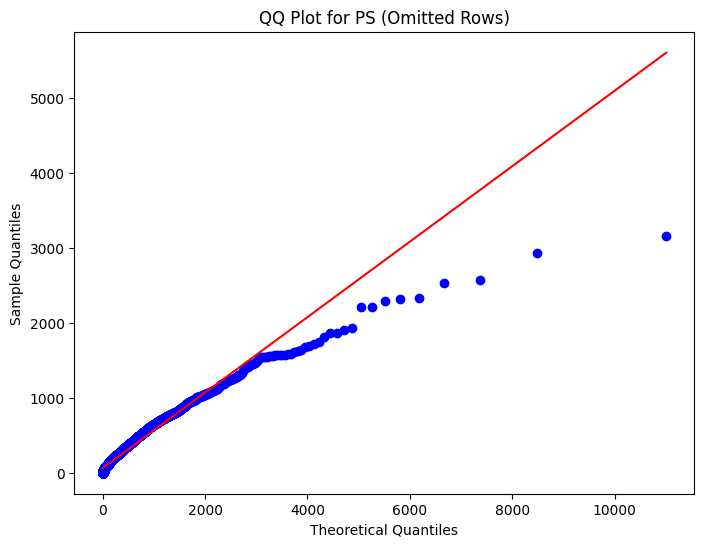

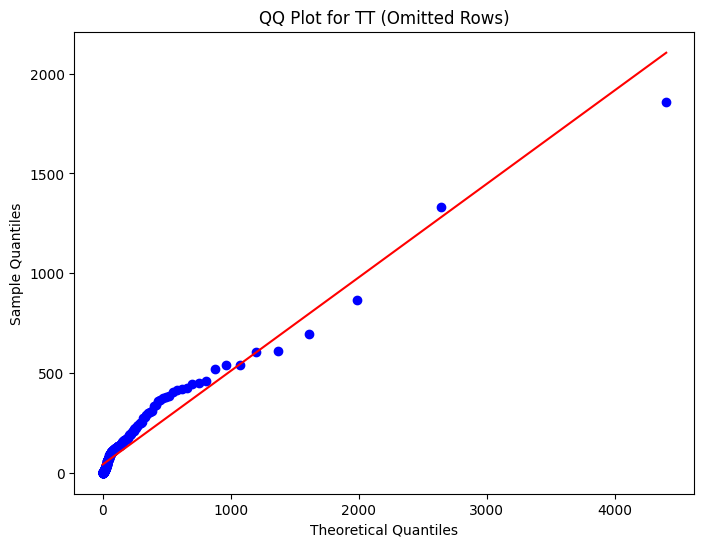

In [190]:
for call_type, group in cc_df_grouped_omit:
    plt.figure(figsize=(8, 6))
    qq_plot_lognorm(group['ser_time'], f'QQ Plot for {call_type} (Omitted Rows)')
    plt.show()

In [191]:
def ks_test_distributions_df(data):
    results = {}

    # Exponential: fit with data mean
    exp_params = (data.mean(),)
    d_exp, p_exp = stats.kstest(data, 'expon', args=exp_params)
    results['exponential'] = {'D-statistic': d_exp, 'p-value': p_exp}

    # Gamma: fit distribution to data
    gamma_params = stats.gamma.fit(data)
    d_gamma, p_gamma = stats.kstest(data, 'gamma', args=gamma_params)
    results['gamma'] = {'D-statistic': d_gamma, 'p-value': p_gamma}

    # Lognormal: fit distribution to data
    lognorm_params = stats.lognorm.fit(data)
    d_lognorm, p_lognorm = stats.kstest(data, 'lognorm', args=lognorm_params)
    results['lognormal'] = {'D-statistic': d_lognorm, 'p-value': p_lognorm}

    # Create DataFrame from results
    df = pd.DataFrame(results).T
    df['reject_null'] = df['p-value'] < 0.05

    # Find best fitting distribution
    best_fit = df['p-value'].idxmax()
    df['best_fit'] = best_fit
    return df


In [192]:
result_dfs = {}
for call_type, group in cc_df_grouped:
    ser_time = group['ser_time']
    result_dfs[call_type] = ks_test_distributions_df(ser_time)
    print(f"{call_type}:\n", result_dfs[call_type], "\n")


IN:
              D-statistic   p-value  reject_null   best_fit
exponential     0.693425  0.000000         True  lognormal
gamma           0.997228  0.000000         True  lognormal
lognormal       0.017896  0.367612        False  lognormal 

NE:
              D-statistic   p-value  reject_null   best_fit
exponential     0.686298  0.000000         True  lognormal
gamma           0.986228  0.000000         True  lognormal
lognormal       0.042321  0.000254         True  lognormal 

NW:
              D-statistic   p-value  reject_null   best_fit
exponential     0.700447  0.000000         True  lognormal
gamma           0.988820  0.000000         True  lognormal
lognormal       0.032918  0.003558         True  lognormal 

PE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.620690  7.497235e-33         True  lognormal
gamma           0.144635  4.729080e-02         True  lognormal
lognormal       0.071029  7.452112e-01        False  lognormal 

PS:
        

In [193]:
result_dfs_omit = {}
for call_type, group in cc_df_grouped_omit:
    ser_time = group['ser_time']
    result_dfs_omit[call_type] = ks_test_distributions_df(ser_time)
    print(f"{call_type} (Omitted Rows):\n", result_dfs_omit[call_type], "\n")

IN (Omitted Rows):
              D-statistic   p-value  reject_null   best_fit
exponential     0.691396  0.000000         True  lognormal
gamma           0.996108  0.000000         True  lognormal
lognormal       0.018537  0.326059        False  lognormal 

NE (Omitted Rows):
              D-statistic   p-value  reject_null   best_fit
exponential     0.680962  0.000000         True  lognormal
gamma           0.979060  0.000000         True  lognormal
lognormal       0.042298  0.000257         True  lognormal 

NW (Omitted Rows):
              D-statistic   p-value  reject_null   best_fit
exponential     0.696907  0.000000         True  lognormal
gamma           0.986841  0.000000         True  lognormal
lognormal       0.032241  0.004613         True  lognormal 

PE (Omitted Rows):
              D-statistic       p-value  reject_null   best_fit
exponential     0.616279  5.712913e-32         True  lognormal
gamma           0.155895  2.722786e-02         True  lognormal
lognormal       0

In [194]:
# Get the parameters of the best fitting distribution for each call type
best_fit_params = {}
for call_type, df in result_dfs.items():
    best_fit = df['best_fit'].iloc[0]
    if best_fit == 'exponential':
        params = (df.loc['exponential', 'D-statistic'],)
    elif best_fit == 'gamma':
        params = stats.gamma.fit(cc_df_grouped.get_group(call_type)['ser_time'])
    elif best_fit == 'lognormal':
        params = stats.lognorm.fit(cc_df_grouped.get_group(call_type)['ser_time'])
    else:
        params = None
    best_fit_params[call_type] = params
    
print("Best fitting distribution parameters for each call type:")
for call_type, params in best_fit_params.items():
    print(f"{call_type}: {params}")

Best fitting distribution parameters for each call type:
IN: (np.float64(1.1350599648314148), -5.203006497328372, np.float64(258.4888605208569))
NE: (np.float64(0.9869587769152067), -18.167823531302567, np.float64(157.02123532999755))
NW: (np.float64(0.9894058505760125), -3.8506544279395962, np.float64(67.7594730138534))
PE: (np.float64(0.8445390237030371), -42.99857382171864, np.float64(228.2646821117295))
PS: (np.float64(0.7784057963424473), -21.656212806011002, np.float64(133.9872685759118))
TT: (np.float64(1.9007403038886572), 0.7870791820498153, np.float64(32.348888274214985))


### Based on the parameters, top 3 longest call types are IN, PE, and NE.

### So lets group top 3 and bottom 3

In [195]:
# Group top 3 and bottom 3 call types based on service time
# Top 3 longest will be COMPLEX call, while bottom 3 will be SIMPLE call
cc_df_typegrouped = cc_df.copy()
cc_df_typegrouped['type_group'] = cc_df_typegrouped['type'].apply(lambda x: 'COMPLEX' if x in ['IN', 'PE', 'NE'] else 'SIMPLE')

# Display the first few rows of the grouped DataFrame
cc_df_typegrouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group
2,44729,PS,1999-09-01,1999-09-01 07:30:37,1999-09-01 07:30:43,6,7:30:43,7:31:22,39,AGENT,1999-09-01 07:31:21,1999-09-01 07:33:11,110,BASCH,SIMPLE
3,44730,PS,1999-09-01,1999-09-01 07:54:21,1999-09-01 07:54:32,11,0:00:00,0:00:00,0,AGENT,1999-09-01 07:54:30,1999-09-01 07:56:58,148,BASCH,SIMPLE
4,44731,PS,1999-09-01,1999-09-01 08:09:37,1999-09-01 08:09:48,11,0:00:00,0:00:00,0,AGENT,1999-09-01 08:09:47,1999-09-01 08:10:41,54,ZOHARI,SIMPLE
5,44732,PS,1999-09-01,1999-09-01 08:28:41,1999-09-01 08:28:50,9,0:00:00,0:00:00,0,AGENT,1999-09-01 08:28:49,1999-09-01 08:29:59,70,STEREN,SIMPLE
6,44733,PS,1999-09-01,1999-09-01 08:39:06,1999-09-01 08:39:16,10,0:00:00,0:00:00,0,AGENT,1999-09-01 08:39:14,1999-09-01 08:40:08,54,ZOHARI,SIMPLE


In [196]:
cc_df_typegrouped_grouped = cc_df_typegrouped.groupby('type_group')

cc_df_typegrouped_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type_group,,,,,,,,
COMPLEX,5199.0,354.538757,527.142768,1.0,86.5,186.0,404.0,14389.0
SIMPLE,21711.0,153.774584,183.650148,1.0,57.0,102.0,185.0,4619.0


### Now we need 2 agent groups from 15 agents. Lets see how each agent perform on simple and complex calls

In [197]:
cc_df_agents = cc_df_typegrouped.groupby(['server','type_group'])

agents_describe = cc_df_agents['ser_time'].describe()

agents_describe

count        mean          std   min     25%    50%  \
server    type_group                                                         
ANAT      COMPLEX      193.0  155.782383   190.959268   1.0   45.00  111.0   
          SIMPLE      1445.0  134.408304   139.299034   1.0   53.00   93.0   
AVI       COMPLEX      145.0  161.082759   170.020648   1.0   48.00  112.0   
          SIMPLE      1272.0  116.955189   147.009895   1.0   47.00   84.0   
AVNI      COMPLEX      127.0  282.755906   203.395374  11.0  117.00  250.0   
          SIMPLE      1029.0  206.110787   228.522290   8.0   87.00  148.0   
BASCH     COMPLEX      151.0  155.198675   190.511628  11.0   52.50  106.0   
          SIMPLE      1822.0  147.266191   147.607219   4.0   57.00  100.0   
BENSION   COMPLEX       14.0   75.500000    46.349425   1.0   56.25   67.0   
          SIMPLE      1061.0  108.038643    98.633108   1.0   48.00   79.0   
DARMON    COMPLEX       45.0  238.200000   268.435416   5.0   74.00  157.0   
          SIMPLE       252.0  279.527778   327.279848  22.0  102.00  175.5   
DORIT     COMPLEX       43.0  262.930233   309.406067  19.0   84.50  165.0   
          SIMPLE      1276.0  177.737461   213.204586   6.0   65.00  110.0   
ELI       COMPLEX      347.0  457.233429   635.478328   4.0  135.00  261.0   
          SIMPLE        69.0  339.434783   307.162607   7.0  138.00  229.0   
GELBER    SIMPLE        66.0  161.166667   147.872251   9.0   62.75  122.5   
GILI      COMPLEX       26.0  230.846154   229.683032  19.0   72.25  138.0   
          SIMPLE       328.0  125.460366   127.358694   3.0   54.00   84.5   
GOLDIE    COMPLEX        4.0   53.750000    18.246004  36.0   41.25   51.0   
          SIMPLE       364.0  193.145604   179.490304   2.0   77.75  130.5   
KAZAV     COMPLEX      120.0  226.525000   203.048198  11.0   78.25  170.0   
          SIMPLE       609.0  155.637110   153.710451   5.0   64.00  107.0   
MEIR      COMPLEX       44.0  276.863636   329.752168  12.0   81.50  159.5   
          SIMPLE       274.0  163.828467   149.326190   6.0   75.50  122.0   
MORIAH    COMPLEX      252.0  149.869048   245.182318   1.0    3.00   37.0   
          SIMPLE      1272.0  140.310535   220.354329   1.0    6.00   79.0   
NAAMA     COMPLEX       26.0  280.000000   351.597383  41.0   95.50  144.0   
          SIMPLE       249.0  192.449799   221.438476   6.0   73.00  121.0   
NO_SERVER COMPLEX       68.0   27.102941    31.946849   3.0    9.00   16.5   
          SIMPLE       332.0   26.027108   176.529079   1.0    4.00    6.0   
PINHAS    SIMPLE       143.0  293.622378   595.614203   6.0   59.00  121.0   
ROTH      COMPLEX      107.0  212.457944   197.571305   6.0   72.50  175.0   
          SIMPLE      1518.0  180.374835   182.673754   6.0   69.00  120.5   
SHARON    COMPLEX      156.0  152.224359   164.988038   4.0   51.75  109.0   
          SIMPLE      1645.0  122.534954   142.119461   2.0   50.00   82.0   
STEREN    COMPLEX      140.0  196.514286   201.740359   3.0   82.75  142.5   
          SIMPLE      1529.0  169.149117   175.811886   3.0   70.00  117.0   
TOVA      COMPLEX      174.0  207.149425   215.679597   1.0   66.50  148.0   
          SIMPLE      1183.0  133.679628   131.770983   1.0   49.00  100.0   
VICKY     COMPLEX      166.0  163.271084   160.902884   1.0   58.25  111.5   
          SIMPLE      1305.0  137.436015   155.157596   1.0   50.00   92.0   
YIFAT     COMPLEX      212.0  332.962264   495.352178   1.0   75.00  164.0   
          SIMPLE       918.0  151.050109   210.505897   1.0   55.00   95.0   
YITZ      COMPLEX       20.0  293.450000   270.501381  44.0  122.75  245.5   
          SIMPLE       685.0  167.867153   164.883003   7.0   71.00  117.0   
Z2ARIE    COMPLEX      225.0  635.080000   787.131412  19.0  152.00  354.0   
Z2ELINOR  COMPLEX      352.0  523.650568   608.411963   1.0  145.50  285.0   
Z2EYAL    COMPLEX      331.0  454.885196   530.505344  23.0  107.00  253.0   
Z2IFAT    COMPLEX      260.0  505.346154  101

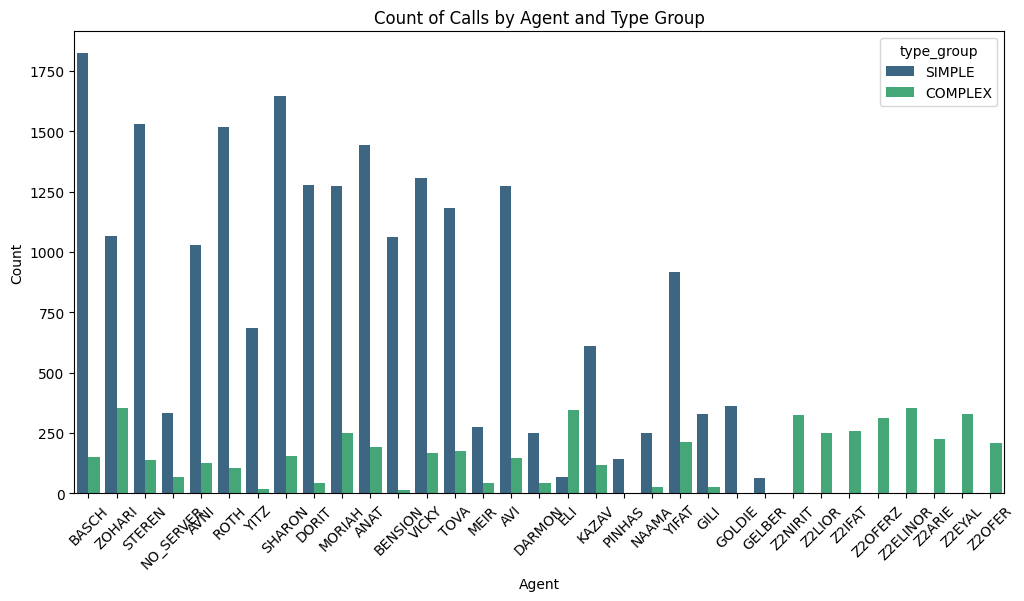

In [198]:
# Bar chart for count of calls by agent and type group
plt.figure(figsize=(12, 6))
sns.countplot(data=cc_df_typegrouped, x='server', hue='type_group', palette='viridis')
plt.title('Count of Calls by Agent and Type Group')
plt.xlabel('Agent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [199]:
# Order agents_describe by simple and complex service time medians
simple_median = agents_describe['50%'].xs('SIMPLE', level='type_group')
complex_median = agents_describe['50%'].xs('COMPLEX', level='type_group')

simple_median.sort_values(ascending=True, inplace=True)
complex_median.sort_values(ascending=True, inplace=True)

print("Simple Median Service Times:\n", simple_median)
print("Complex Median Service Times:\n", complex_median)

Simple Median Service Times:
 server
NO_SERVER      6.0
BENSION       79.0
MORIAH        79.0
SHARON        82.0
AVI           84.0
GILI          84.5
VICKY         92.0
ANAT          93.0
YIFAT         95.0
TOVA         100.0
BASCH        100.0
KAZAV        107.0
DORIT        110.0
STEREN       117.0
YITZ         117.0
ROTH         120.5
NAAMA        121.0
PINHAS       121.0
MEIR         122.0
GELBER       122.5
GOLDIE       130.5
ZOHARI       146.0
AVNI         148.0
DARMON       175.5
ELI          229.0
Name: 50%, dtype: float64
Complex Median Service Times:
 server
NO_SERVER     16.5
MORIAH        37.0
GOLDIE        51.0
BENSION       67.0
BASCH        106.0
SHARON       109.0
ANAT         111.0
VICKY        111.5
AVI          112.0
GILI         138.0
STEREN       142.5
NAAMA        144.0
TOVA         148.0
DARMON       157.0
MEIR         159.5
YIFAT        164.0
DORIT        165.0
KAZAV        170.0
ROTH         175.0
ZOHARI       183.0
Z2NIRIT      217.5
YITZ         245.5
AVNI  

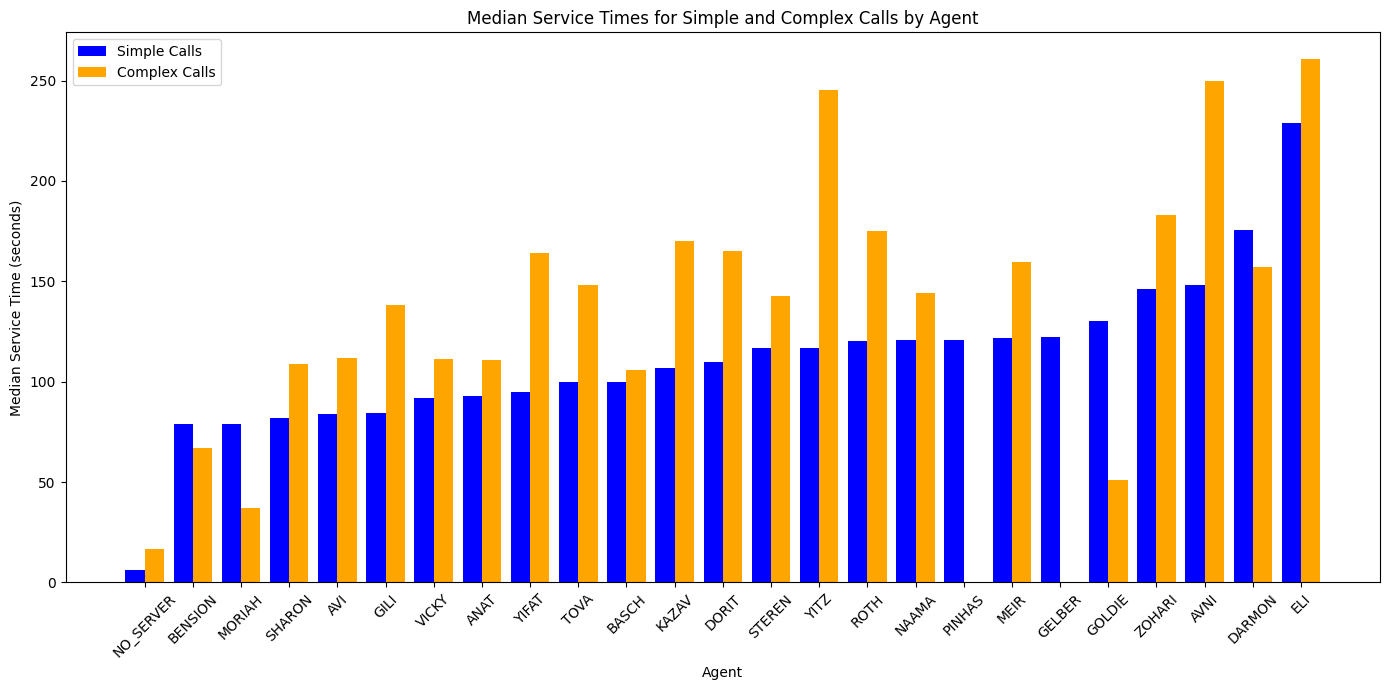

In [200]:
# Plot the median service times for simple and complex calls by agent
plt.figure(figsize=(14, 7))
agents = simple_median.index
x = np.arange(len(agents))

plt.bar(x - 0.2, simple_median.values, width=0.4, label='Simple Calls', color='blue')
plt.bar(x + 0.2, complex_median.reindex(agents).values, width=0.4, label='Complex Calls', color='orange')

plt.xticks(x, agents, rotation=45)
plt.title('Median Service Times for Simple and Complex Calls by Agent')
plt.xlabel('Agent')
plt.ylabel('Median Service Time (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

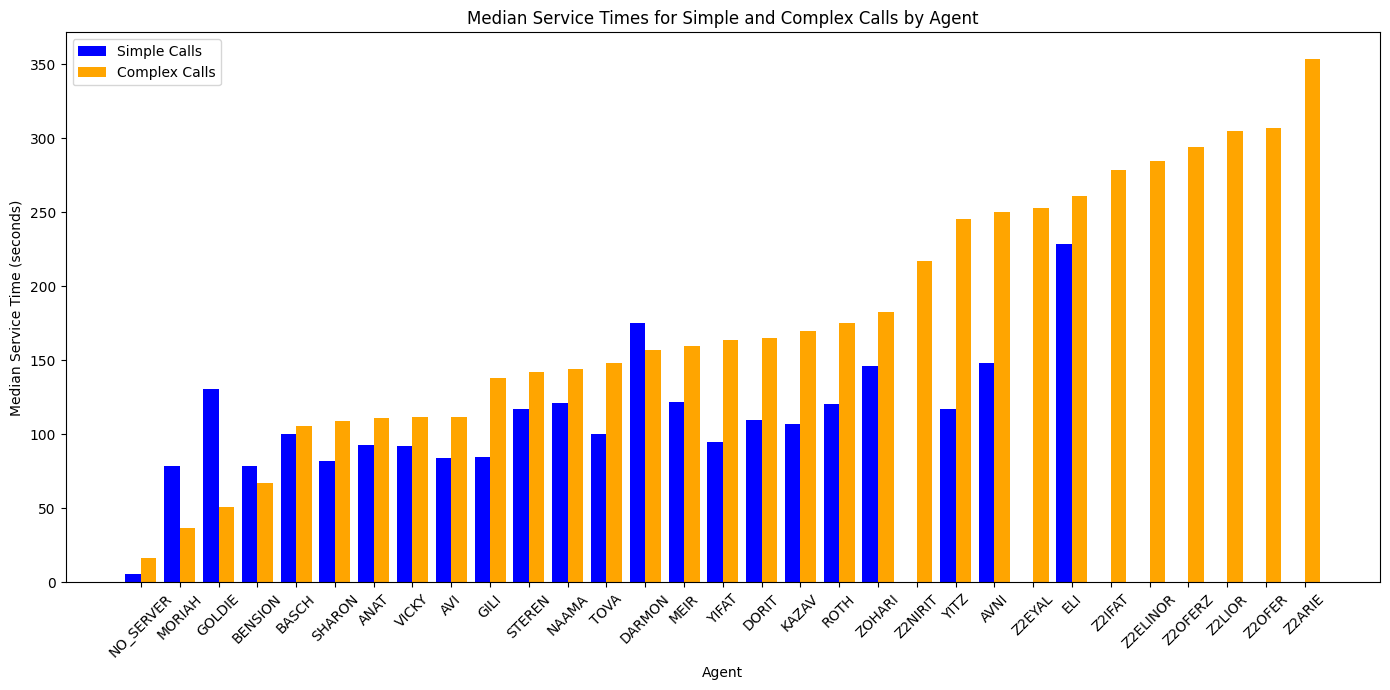

In [201]:
# Plot the median service times for simple and complex calls by agent
plt.figure(figsize=(14, 7))
agents = complex_median.index
x = np.arange(len(agents))

plt.bar(x - 0.2, simple_median.reindex(agents).values, width=0.4, label='Simple Calls', color='blue')
plt.bar(x + 0.2, complex_median.values, width=0.4, label='Complex Calls', color='orange')

plt.xticks(x, agents, rotation=45)
plt.title('Median Service Times for Simple and Complex Calls by Agent')
plt.xlabel('Agent')
plt.ylabel('Median Service Time (seconds)')
plt.legend()
plt.tight_layout()
plt.show()

### Based on these, we group the servers to Group 1: Quick at Simple Calls, Slow at Complex Calls, and Group 2: Slow at Simple Calls, Quick at Complex Calls

In [202]:
# Define the groupings
group_1 = [
    'AVI', 'AVNI', 'BENSION', 'DORIT', 'GILI', 'KAZAV', 'MORIAH', 'NO_SERVER', 'PINHAS',
    'ROTH', 'SHARON', 'TOVA', 'YIFAT', 'YITZ', 'Z2ARIE', 'Z2ELINOR', 'Z2EYAL',
    'Z2IFAT', 'Z2LIOR', 'Z2OFER', 'Z2OFERZ'
]
group_2 = [
    'ANAT', 'BASCH', 'DARMON', 'ELI', 'GELBER', 'GOLDIE',
    'MEIR', 'NAAMA', 'STEREN', 'VICKY', 'ZOHARI', 'Z2NIRIT'
]

def assign_group(server):
    if server in group_1:
        return 1
    elif server in group_2:
        return 2
    else:
        return None

# Add the 'server_group' column to the DataFrame
cc_df_agentgrouped = cc_df_typegrouped.copy()
cc_df_agentgrouped['server_group'] = cc_df_typegrouped['server'].map(assign_group)

cc_df_agentgrouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group,server_group
2,44729,PS,1999-09-01,1999-09-01 07:30:37,1999-09-01 07:30:43,6,7:30:43,7:31:22,39,AGENT,1999-09-01 07:31:21,1999-09-01 07:33:11,110,BASCH,SIMPLE,2
3,44730,PS,1999-09-01,1999-09-01 07:54:21,1999-09-01 07:54:32,11,0:00:00,0:00:00,0,AGENT,1999-09-01 07:54:30,1999-09-01 07:56:58,148,BASCH,SIMPLE,2
4,44731,PS,1999-09-01,1999-09-01 08:09:37,1999-09-01 08:09:48,11,0:00:00,0:00:00,0,AGENT,1999-09-01 08:09:47,1999-09-01 08:10:41,54,ZOHARI,SIMPLE,2
5,44732,PS,1999-09-01,1999-09-01 08:28:41,1999-09-01 08:28:50,9,0:00:00,0:00:00,0,AGENT,1999-09-01 08:28:49,1999-09-01 08:29:59,70,STEREN,SIMPLE,2
6,44733,PS,1999-09-01,1999-09-01 08:39:06,1999-09-01 08:39:16,10,0:00:00,0:00:00,0,AGENT,1999-09-01 08:39:14,1999-09-01 08:40:08,54,ZOHARI,SIMPLE,2


In [203]:
cc_df_agentgrouped_grouped = cc_df_agentgrouped.groupby(['server_group', 'type_group'])

cc_df_agentgrouped_grouped['ser_time'].describe()

count        mean         std  min   25%    50%  \
server_group type_group                                                      
1            COMPLEX      3401.0  387.906498  572.035366  1.0  90.0  204.0   
             SIMPLE      13271.0  147.275262  189.000959  1.0  52.0   96.0   
2            COMPLEX      1798.0  291.422136  422.585165  1.0  82.0  167.0   
             SIMPLE       8440.0  163.994076  174.427722  1.0  63.0  112.0   

                           75%      max  
server_group type_group                  
1            COMPLEX     454.0  14389.0  
             SIMPLE      177.0   4619.0  
2            COMPLEX     317.0   7387.0  
             SIMPLE      197.0   3158.0

* Simple have more count
* First group do better on simple, second group on complex
* Avg_s_1 < Avg_s_2 < Avg_c_2 < Avg_c_1

All fits the limitation of the theoretical model

### Now lets check the distribution of ser_time for each agent groups

In [204]:
agents_group_results = {}
for (server_group, type_group), group in cc_df_agentgrouped_grouped:
    ser_time = group['ser_time']
    agents_group_results[(server_group, type_group)] = ks_test_distributions_df(ser_time)
    print(f"Server Group: {server_group}, Type Group: {type_group}:\n", agents_group_results[(server_group, type_group)], "\n")

Server Group: 1, Type Group: COMPLEX:
              D-statistic   p-value  reject_null   best_fit
exponential     0.709203  0.000000         True  lognormal
gamma           0.991863  0.000000         True  lognormal
lognormal       0.026847  0.014584         True  lognormal 

Server Group: 1, Type Group: SIMPLE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.683596  0.000000e+00         True  lognormal
gamma           0.981381  0.000000e+00         True  lognormal
lognormal       0.041567  2.317959e-20         True  lognormal 

Server Group: 2, Type Group: COMPLEX:
              D-statistic   p-value  reject_null   best_fit
exponential     0.724138  0.000000         True  lognormal
gamma           0.990816  0.000000         True  lognormal
lognormal       0.031053  0.061086        False  lognormal 

Server Group: 2, Type Group: SIMPLE:
              D-statistic   p-value  reject_null   best_fit
exponential     0.674171  0.000000         True  lognorma

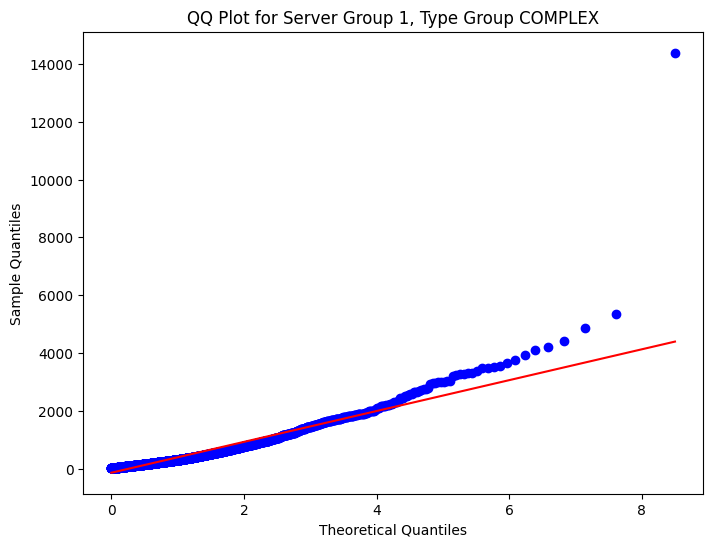

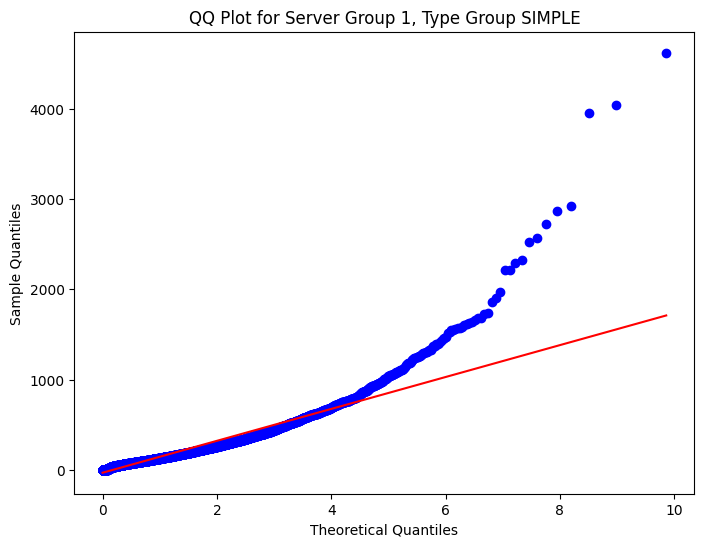

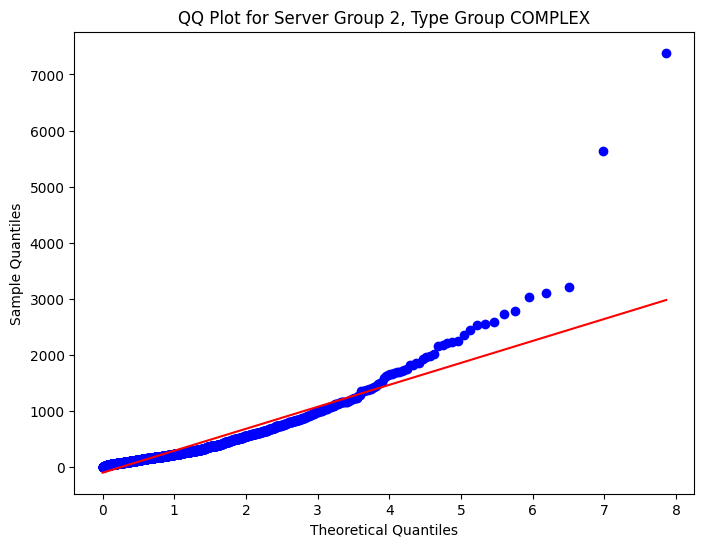

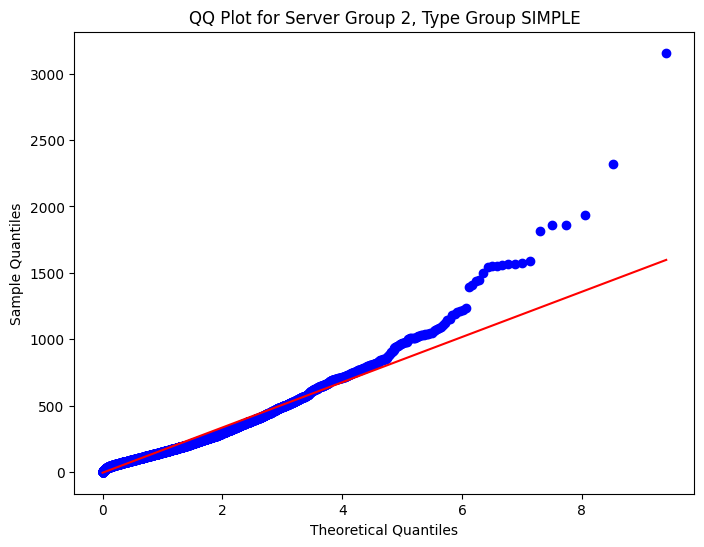

In [205]:
# QQ Plot for each agent group
for (server_group, type_group), group in cc_df_agentgrouped_grouped:
    plt.figure(figsize=(8, 6))
    qq_plot_exp(group['ser_time'], f'QQ Plot for Server Group {server_group}, Type Group {type_group}')
    plt.show()

In [206]:
# Fit the best fitting distribution for each agent group
best_fit_service_params = {}
for (server_group, type_group), df in agents_group_results.items():
    best_fit = df['best_fit'].iloc[0]
    if best_fit == 'exponential':
        params = (df.loc['exponential', 'D-statistic'],)
    elif best_fit == 'gamma':
        params = stats.gamma.fit(cc_df_agentgrouped_grouped.get_group((server_group, type_group))['ser_time'])
    elif best_fit == 'lognormal':
        params = stats.lognorm.fit(cc_df_agentgrouped_grouped.get_group((server_group, type_group))['ser_time'])
    else:
        params = None
    best_fit_service_params[(server_group, type_group)] = params
print("Best fitting distribution parameters for each agent group:")
for (server_group, type_group), params in best_fit_service_params.items():
    print(f"Server Group {server_group}, Type Group {type_group}: {params}")
    

Best fitting distribution parameters for each agent group:
Server Group 1, Type Group COMPLEX: (np.float64(1.1567506309175604), -13.697371691313027, np.float64(213.91021257288995))
Server Group 1, Type Group SIMPLE: (np.float64(0.8714417565068412), -16.34416951673067, np.float64(111.60852729968671))
Server Group 2, Type Group COMPLEX: (np.float64(0.9968731202764275), -11.311979635977982, np.float64(180.77895252502313))
Server Group 2, Type Group SIMPLE: (np.float64(0.7842025653246896), -14.933594007072074, np.float64(130.3691080385467))


### Finally, get the interarrivals for simple and complex calls

In [207]:
# Split the DataFrame into two groups based on type_group
cc_df_simple_grouped = cc_df_agentgrouped[cc_df_agentgrouped['type_group'] == 'SIMPLE']
cc_df_complex_grouped = cc_df_agentgrouped[cc_df_agentgrouped['type_group'] == 'COMPLEX']

# Make sure the dataframes are sorted by vru_entry
cc_df_simple_grouped = cc_df_simple_grouped.sort_values(by='vru_entry')
cc_df_complex_grouped = cc_df_complex_grouped.sort_values(by='vru_entry')

cc_df_simple_grouped.head(), cc_df_complex_grouped.head()

(       call_id type       date           vru_entry            vru_exit  \
 2675     32464   PS 1999-09-01 1999-09-01 07:02:24 1999-09-01 07:02:30   
 6937     39566   PS 1999-09-01 1999-09-01 07:03:06 1999-09-01 07:03:15   
 27164    26094   PS 1999-09-01 1999-09-01 07:03:53 1999-09-01 07:04:02   
 12694    45465   PS 1999-09-01 1999-09-01 07:04:19 1999-09-01 07:04:25   
 9621      4094   TT 1999-09-01 1999-09-01 07:05:45 1999-09-01 07:05:47   
 
        vru_time  q_start   q_exit  q_time outcome           ser_start  \
 2675          6  7:02:30  7:02:49      19   AGENT 1999-09-01 07:02:49   
 6937          9  0:00:00  0:00:00       0   AGENT 1999-09-01 07:03:14   
 27164         9  0:00:00  0:00:00       0   AGENT 1999-09-01 07:04:02   
 12694         6  7:04:25  7:05:14      49   AGENT 1999-09-01 07:05:13   
 9621          2  0:00:00  0:00:00       0   AGENT 1999-09-01 07:05:46   
 
                  ser_exit  ser_time  server type_group  server_group  
 2675  1999-09-01 07:03:30    

In [208]:
# Calculate interarrival times
cc_df_simple_grouped['interarrival_time'] = (
    cc_df_simple_grouped.groupby('date')['vru_entry'].diff()
).dt.total_seconds()
cc_df_complex_grouped['interarrival_time'] = (
    cc_df_complex_grouped.groupby('date')['vru_entry'].diff()
).dt.total_seconds()

# Move column near vru_entry
cc_df_simple_grouped = cc_df_simple_grouped[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + 
                                              [col for col in cc_df_simple_grouped.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]
cc_df_complex_grouped = cc_df_complex_grouped[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + 
                                                [col for col in cc_df_complex_grouped.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]

# Display the first few rows of the DataFrame with interarrival times
cc_df_simple_grouped.head(), cc_df_complex_grouped.head()

(       call_id type       date           vru_entry  interarrival_time  \
 2675     32464   PS 1999-09-01 1999-09-01 07:02:24                NaN   
 6937     39566   PS 1999-09-01 1999-09-01 07:03:06               42.0   
 27164    26094   PS 1999-09-01 1999-09-01 07:03:53               47.0   
 12694    45465   PS 1999-09-01 1999-09-01 07:04:19               26.0   
 9621      4094   TT 1999-09-01 1999-09-01 07:05:45               86.0   
 
                  vru_exit  vru_time  q_start   q_exit  q_time outcome  \
 2675  1999-09-01 07:02:30         6  7:02:30  7:02:49      19   AGENT   
 6937  1999-09-01 07:03:15         9  0:00:00  0:00:00       0   AGENT   
 27164 1999-09-01 07:04:02         9  0:00:00  0:00:00       0   AGENT   
 12694 1999-09-01 07:04:25         6  7:04:25  7:05:14      49   AGENT   
 9621  1999-09-01 07:05:47         2  0:00:00  0:00:00       0   AGENT   
 
                 ser_start            ser_exit  ser_time  server type_group  \
 2675  1999-09-01 07:02:49 19

In [209]:
cc_df_simple_grouped['interarrival_time'].describe(), cc_df_complex_grouped['interarrival_time'].describe()

(count    21682.000000
 mean        61.608062
 std         74.778967
 min          0.000000
 25%         16.000000
 50%         39.000000
 75%         79.000000
 max       1358.000000
 Name: interarrival_time, dtype: float64,
 count    5170.000000
 mean      249.914894
 std       328.793550
 min         0.000000
 25%        62.000000
 50%       146.000000
 75%       309.000000
 max      5480.000000
 Name: interarrival_time, dtype: float64)

In [210]:
# Check the top 10 highest interarrival times
cc_df_simple_grouped.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group,server_group
21511,10238,PS,1999-09-25,1999-09-25 20:06:49,1358.0,1999-09-25 20:07:02,13,0:00:00,0:00:00,0,AGENT,1999-09-25 20:07:01,1999-09-25 20:08:55,114,AVI,SIMPLE,1
17851,46755,PS,1999-09-26,1999-09-26 23:30:31,1339.0,1999-09-26 23:30:42,11,0:00:00,0:00:00,0,AGENT,1999-09-26 23:30:41,1999-09-26 23:32:44,123,MORIAH,SIMPLE,1
6924,3795,TT,1999-09-28,1999-09-28 19:29:09,1245.0,1999-09-28 19:29:11,2,0:00:00,0:00:00,0,AGENT,1999-09-28 19:29:10,1999-09-28 19:32:42,212,SHARON,SIMPLE,1
28000,26938,PS,1999-09-20,1999-09-20 23:44:17,1079.0,1999-09-20 23:44:26,9,0:00:00,0:00:00,0,AGENT,1999-09-20 23:44:25,1999-09-20 23:45:08,43,DORIT,SIMPLE,1
15411,49318,PS,1999-09-30,1999-09-30 20:33:22,1052.0,1999-09-30 20:33:30,8,0:00:00,0:00:00,0,AGENT,1999-09-30 20:33:29,1999-09-30 20:37:22,233,STEREN,SIMPLE,2
8132,40772,PS,1999-09-27,1999-09-27 23:08:11,924.0,1999-09-27 23:08:25,14,0:00:00,0:00:00,0,AGENT,1999-09-27 23:08:24,1999-09-27 23:11:41,197,SHARON,SIMPLE,1
22455,10171,PS,1999-09-15,1999-09-15 07:20:56,886.0,1999-09-15 07:21:11,15,0:00:00,0:00:00,0,AGENT,1999-09-15 07:21:11,1999-09-15 07:25:38,267,VICKY,SIMPLE,2
3195,32993,PS,1999-09-09,1999-09-09 23:46:22,858.0,1999-09-09 23:46:33,11,0:00:00,0:00:00,0,AGENT,1999-09-09 23:46:33,1999-09-09 23:48:58,145,AVI,SIMPLE,1
28440,27379,PS,1999-09-30,1999-09-30 17:54:21,812.0,1999-09-30 17:54:32,11,0:00:00,0:00:00,0,AGENT,1999-09-30 17:54:31,1999-09-30 17:58:12,221,VICKY,SIMPLE,2
6254,46724,NW,1999-09-19,1999-09-19 11:56:02,809.0,1999-09-19 11:56:11,9,11:56:11,11:56:28,17,AGENT,1999-09-19 11:56:28,1999-09-19 11:57:03,35,AVNI,SIMPLE,1


In [211]:
cc_df_complex_grouped.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group,server_group
15189,49095,NE,1999-09-25,1999-09-25 23:42:24,5480.0,1999-09-25 23:42:35,11,0:00:00,0:00:00,0,AGENT,1999-09-25 23:42:34,1999-09-25 23:47:50,316,ZOHARI,COMPLEX,2
30867,11532,IN,1999-09-18,1999-09-18 23:21:51,4275.0,1999-09-18 23:22:08,17,0:00:00,0:00:00,0,AGENT,1999-09-18 23:22:07,1999-09-18 23:24:37,150,Z2ELINOR,COMPLEX,1
15410,49317,NE,1999-09-30,1999-09-30 19:56:30,4119.0,1999-09-30 19:56:39,9,0:00:00,0:00:00,0,AGENT,1999-09-30 19:56:39,1999-09-30 20:02:41,362,AVNI,COMPLEX,1
4862,45913,NE,1999-09-16,1999-09-16 23:58:48,3681.0,1999-09-16 23:58:58,10,0:00:00,0:00:00,0,AGENT,1999-09-16 23:58:57,1999-09-16 00:01:39,162,AVNI,COMPLEX,1
27689,26623,PE,1999-09-10,1999-09-10 08:04:47,3315.0,1999-09-10 08:04:57,10,0:00:00,0:00:00,0,AGENT,1999-09-10 08:04:56,1999-09-10 08:07:13,137,DORIT,COMPLEX,1
12510,9036,IN,1999-09-27,1999-09-27 08:07:09,3098.0,1999-09-27 08:07:23,14,0:00:00,0:00:00,0,AGENT,1999-09-27 08:07:22,1999-09-27 08:20:37,795,Z2OFER,COMPLEX,1
17855,46759,NE,1999-09-27,1999-09-27 08:56:18,2949.0,1999-09-27 08:56:31,13,0:00:00,0:00:00,0,AGENT,1999-09-27 08:56:30,1999-09-27 08:58:43,133,ELI,COMPLEX,2
18853,49152,NE,1999-09-24,1999-09-24 09:25:21,2934.0,1999-09-24 09:25:30,9,0:00:00,0:00:00,0,AGENT,1999-09-24 09:25:29,1999-09-24 09:28:42,193,BASCH,COMPLEX,2
30869,11534,IN,1999-09-19,1999-09-19 08:17:12,2842.0,1999-09-19 08:17:30,18,0:00:00,0:00:00,0,AGENT,1999-09-19 08:17:29,1999-09-19 08:45:55,1706,Z2IFAT,COMPLEX,1
21729,10457,NE,1999-09-30,1999-09-30 17:42:18,2714.0,1999-09-30 17:42:23,5,17:42:23,17:43:06,43,AGENT,1999-09-30 17:43:06,1999-09-30 17:44:41,95,STEREN,COMPLEX,2


In [212]:
# Display the count of simple and complex calls with interarrival time
cc_df_simple_grouped['interarrival_time'].count(), cc_df_complex_grouped['interarrival_time'].count()

(np.int64(21682), np.int64(5170))

In [213]:
# Check how many calls with 0 interarrival time
cc_df_simple_grouped[cc_df_simple_grouped['interarrival_time'] == 0].shape[0], cc_df_complex_grouped[cc_df_complex_grouped['interarrival_time'] == 0].shape[0]

(181, 11)

In [214]:
# Check several rows around one record with 0 interarrival time

# Get the label of the first 0 interarrival time
zero_label_simple = cc_df_simple_grouped[cc_df_simple_grouped['interarrival_time'] == 0].index[0]
# Find its integer position
pos = cc_df_simple_grouped.index.get_loc(zero_label_simple)
# Use .iloc for slicing around
cc_df_simple_grouped.iloc[pos - 3 : pos + 4]

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group,server_group
8,44735,PS,1999-09-01,1999-09-01 09:06:29,16.0,1999-09-01 09:06:34,5,9:06:34,9:06:58,24,AGENT,1999-09-01 09:06:57,1999-09-01 09:08:07,70,BASCH,SIMPLE,2
25815,26561,PS,1999-09-01,1999-09-01 09:07:01,32.0,1999-09-01 09:07:06,5,9:07:06,9:09:22,136,AGENT,1999-09-01 09:09:21,1999-09-01 09:10:49,88,STEREN,SIMPLE,2
2682,32471,NW,1999-09-01,1999-09-01 09:07:30,29.0,1999-09-01 09:07:40,10,9:07:40,9:09:26,106,AGENT,1999-09-01 09:09:25,1999-09-01 09:11:46,141,BASCH,SIMPLE,2
1356,35837,PS,1999-09-01,1999-09-01 09:07:30,0.0,1999-09-01 09:07:36,6,9:07:36,9:08:24,48,AGENT,1999-09-01 09:08:24,1999-09-01 09:09:11,47,BASCH,SIMPLE,2
6944,39573,PS,1999-09-01,1999-09-01 09:07:51,21.0,1999-09-01 09:07:56,5,9:07:56,9:09:11,75,AGENT,1999-09-01 09:09:10,1999-09-01 09:11:10,120,DORIT,SIMPLE,1
12701,45472,PS,1999-09-01,1999-09-01 09:09:20,89.0,1999-09-01 09:09:26,6,9:09:26,9:09:38,12,AGENT,1999-09-01 09:09:36,1999-09-01 09:11:40,124,ROTH,SIMPLE,1
23104,46459,PS,1999-09-01,1999-09-01 09:10:02,42.0,1999-09-01 09:10:07,5,9:10:07,9:10:30,23,AGENT,1999-09-01 09:10:29,1999-09-01 09:12:41,132,AVNI,SIMPLE,1


In [215]:
# For complex group

# Get the label of the first 0 interarrival time
zero_label_complex = cc_df_complex_grouped[cc_df_complex_grouped['interarrival_time'] == 0].index[0]
# Find its integer position
pos = cc_df_complex_grouped.index.get_loc(zero_label_complex)
# Use .iloc for slicing around
cc_df_complex_grouped.iloc[pos - 3 : pos + 4]

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,type_group,server_group
11180,7704,IN,1999-09-02,1999-09-02 09:42:38,29.0,1999-09-02 09:42:54,16,0:00:00,0:00:00,0,AGENT,1999-09-02 09:42:53,1999-09-02 09:52:39,586,Z2ARIE,COMPLEX,1
25886,26632,NE,1999-09-02,1999-09-02 09:45:26,168.0,1999-09-02 09:45:37,11,0:00:00,0:00:00,0,AGENT,1999-09-02 09:45:35,1999-09-02 09:49:58,263,ELI,COMPLEX,2
29889,10553,IN,1999-09-02,1999-09-02 09:51:13,347.0,1999-09-02 09:51:34,21,0:00:00,0:00:00,0,AGENT,1999-09-02 09:51:33,1999-09-02 09:56:37,304,Z2IFAT,COMPLEX,1
78,44805,NE,1999-09-02,1999-09-02 09:51:13,0.0,1999-09-02 09:51:23,10,0:00:00,0:00:00,0,AGENT,1999-09-02 09:51:23,1999-09-02 09:53:46,143,ELI,COMPLEX,2
1426,35907,NE,1999-09-02,1999-09-02 09:52:18,65.0,1999-09-02 09:52:24,6,9:52:24,9:53:12,48,AGENT,1999-09-02 09:53:11,1999-09-02 09:57:06,235,TOVA,COMPLEX,1
14126,48023,NE,1999-09-02,1999-09-02 09:54:56,158.0,1999-09-02 09:55:09,13,0:00:00,0:00:00,0,AGENT,1999-09-02 09:55:07,1999-09-02 09:58:00,173,ELI,COMPLEX,2
12772,45543,NE,1999-09-02,1999-09-02 10:00:29,333.0,1999-09-02 10:00:39,10,0:00:00,0:00:00,0,AGENT,1999-09-02 10:00:38,1999-09-02 10:06:43,365,ELI,COMPLEX,2


### Does not seem to be anomalies, lets just change it to 1 second

In [216]:
# Calculate the percentage of calls with 0 interarrival time
simple_zero_percentage = (cc_df_simple_grouped['interarrival_time'] == 0).mean() * 100
complex_zero_percentage = (cc_df_complex_grouped['interarrival_time'] == 0).mean() * 100

print(f"Percentage of calls with 0 interarrival time (Simple): {simple_zero_percentage:.2f}%")
print(f"Percentage of calls with 0 interarrival time (Complex): {complex_zero_percentage:.2f}%")

Percentage of calls with 0 interarrival time (Simple): 0.83%
Percentage of calls with 0 interarrival time (Complex): 0.21%


In [230]:
# Change rows with 0 interarrival time to 1 second
cc_df_simple_grouped.loc[cc_df_simple_grouped['interarrival_time'] == 0, 'interarrival_time'] = 1
cc_df_complex_grouped.loc[cc_df_complex_grouped['interarrival_time'] == 0, 'interarrival_time'] = 1 

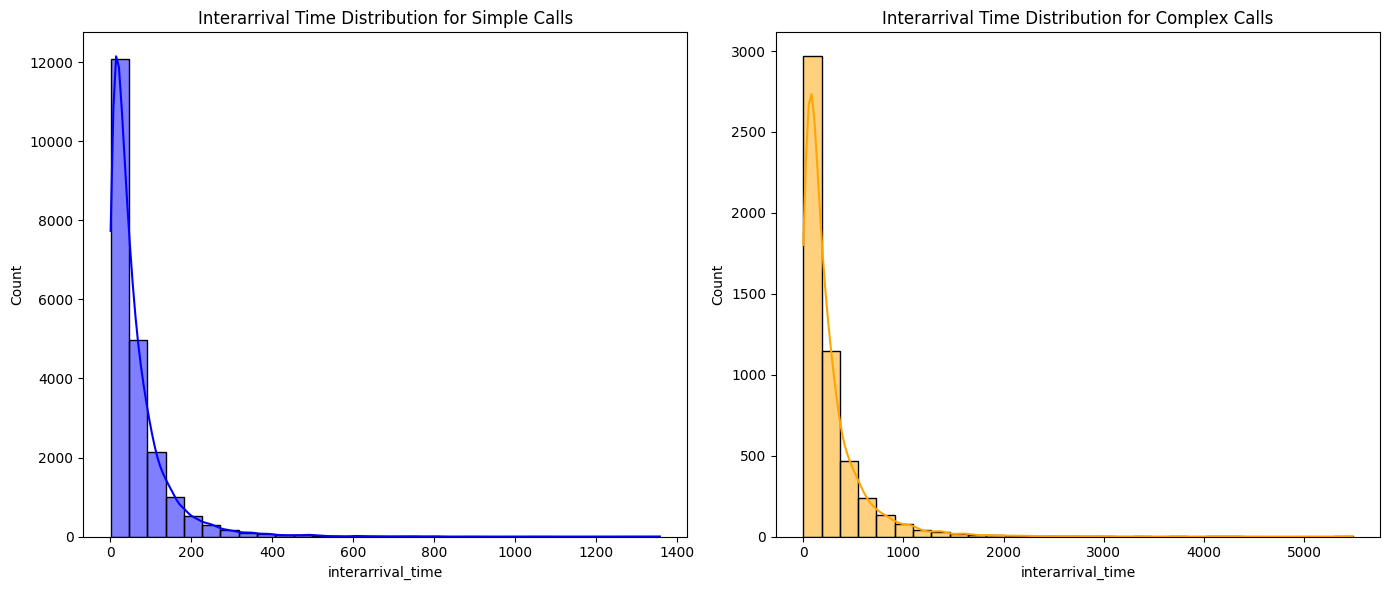

In [231]:
# Plot the histogram of interarrival times for simple and complex calls
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.histplot(cc_df_simple_grouped['interarrival_time'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Interarrival Time Distribution for Simple Calls')
sns.histplot(cc_df_complex_grouped['interarrival_time'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Interarrival Time Distribution for Complex Calls')
plt.tight_layout()
plt.show()

In [232]:
# Remove NA values in interarrival time
cc_df_simple_grouped = cc_df_simple_grouped.dropna(subset=['interarrival_time'])
cc_df_complex_grouped = cc_df_complex_grouped.dropna(subset=['interarrival_time'])

simple_results = ks_test_distributions_df(cc_df_simple_grouped['interarrival_time'])
complex_results = ks_test_distributions_df(cc_df_complex_grouped['interarrival_time'])

print("Simple Group Results:\n", simple_results, "\n")
print("Complex Group Results:\n", complex_results, "\n")

Simple Group Results:
              D-statistic       p-value  reject_null   best_fit
exponential     0.668108  0.000000e+00         True  lognormal
gamma           0.067864  1.521290e-86         True  lognormal
lognormal       0.031246  1.133697e-18         True  lognormal 

Complex Group Results:
              D-statistic   p-value  reject_null   best_fit
exponential     0.679395  0.000000         True  lognormal
gamma           0.989029  0.000000         True  lognormal
lognormal       0.024624  0.003773         True  lognormal 



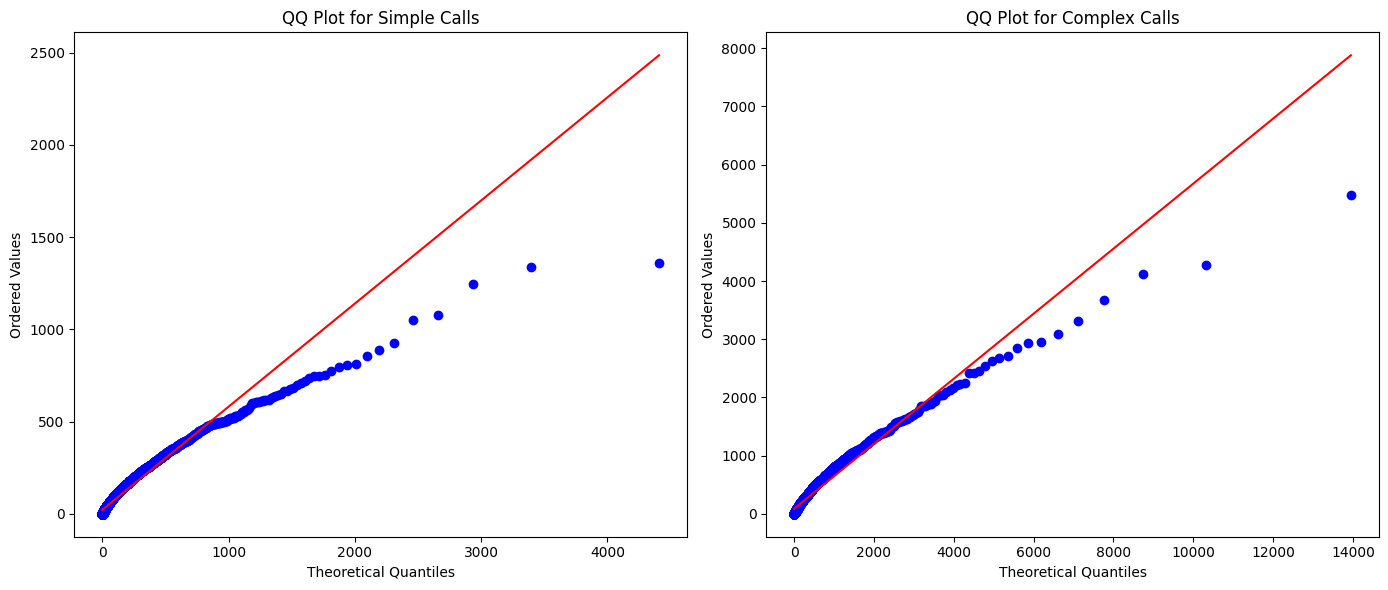

In [233]:
# QQ plots for interarrival times with lognormal distribution
shape_simple, loc_simple, scale_simple = stats.lognorm.fit(cc_df_simple_grouped['interarrival_time'], floc=0)
shape_complex, loc_complex, scale_complex = stats.lognorm.fit(cc_df_complex_grouped['interarrival_time'], floc=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
stats.probplot(cc_df_simple_grouped['interarrival_time'], dist="lognorm", sparams=(shape_simple, loc_simple, scale_simple), plot=axes[0])
axes[0].set_title('QQ Plot for Simple Calls')
axes[0].set_xlabel('Theoretical Quantiles')

stats.probplot(cc_df_complex_grouped['interarrival_time'], dist="lognorm", sparams=(shape_complex, loc_complex, scale_complex), plot=axes[1])
axes[1].set_title('QQ Plot for Complex Calls')
axes[1].set_xlabel('Theoretical Quantiles')

plt.tight_layout()
plt.show()

In [234]:
# Create a dictionary to store the best fitting distribution parameters for interarrival times
best_fit_interarrival_params = {}
best_fit_interarrival_params['SIMPLE'] = (shape_simple, loc_simple, scale_simple)
best_fit_interarrival_params['COMPLEX'] = (shape_complex, loc_complex, scale_complex)

best_fit_interarrival_params


{'SIMPLE': (np.float64(1.217607040788055), 0, np.float64(33.98447574087607)),
 'COMPLEX': (np.float64(1.285176797608705), 0, np.float64(129.03645775754975))}

In [235]:
best_fit_service_params

{(np.int64(1), 'COMPLEX'): (np.float64(1.1567506309175604),
  -13.697371691313027,
  np.float64(213.91021257288995)),
 (np.int64(1), 'SIMPLE'): (np.float64(0.8714417565068412),
  -16.34416951673067,
  np.float64(111.60852729968671)),
 (np.int64(2), 'COMPLEX'): (np.float64(0.9968731202764275),
  -11.311979635977982,
  np.float64(180.77895252502313)),
 (np.int64(2), 'SIMPLE'): (np.float64(0.7842025653246896),
  -14.933594007072074,
  np.float64(130.3691080385467))}

In [236]:
# Create df to store the best fitting distribution parameters

best_fit_service_params_df = pd.DataFrame.from_dict(best_fit_service_params, orient='index', columns=['shape', 'loc', 'scale'])
best_fit_interarrival_params_df = pd.DataFrame.from_dict(best_fit_interarrival_params, orient='index', columns=['shape', 'loc', 'scale'])

best_fit_params_df = pd.concat([best_fit_service_params_df, best_fit_interarrival_params_df])

best_fit_params_df = best_fit_params_df.reset_index().rename(columns={'index': 'param_name'})
best_fit_params_df

,param_name,shape,loc,scale
0,"(1, COMPLEX)",1.156751,-13.697372,213.910213
1,"(1, SIMPLE)",0.871442,-16.344170,111.608527
2,"(2, COMPLEX)",0.996873,-11.311980,180.778953
3,"(2, SIMPLE)",0.784203,-14.933594,130.369108
4,SIMPLE,1.217607,0.000000,33.984476
5,COMPLEX,1.285177,0.000000,129.036458


In [238]:
# Save the best fitting parameters to a pickle file
with open('pickles/best_fit_lognorm_params_anonbank.pkl', 'wb') as f:
    pickle.dump(best_fit_params_df, f)
print("Best fitting parameters saved to 'best_fit_lognorm_params_anonbank.pkl'")

Best fitting parameters saved to 'best_fit_lognorm_params_anonbank.pkl'


In [ ]:
import random